In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pyranges as pr


In [2]:
#Read GTEx targets

targets_df = pd.read_csv('/home/jlinder/borzoi_sc/borzoi/examples/targets_rna3_only.txt', index_col=0, sep='\t')

#Get target strands
targets_strand = []
for ti, identifier in enumerate(targets_df.identifier):
    if targets_df.index[ti] == targets_df.strand_pair.iloc[ti]:
        targets_strand.append('.')
    else:
        targets_strand.append(identifier[-1])

targets_df['strand'] = targets_strand

#Select only one strand
strand_mask = (targets_df.strand != '-')
targets_strand_df = targets_df[strand_mask].copy()


In [3]:
#Store original target indices

targets_strand_df['row_index'] = np.arange(len(targets_strand_df), dtype='int32')


In [4]:
#Compile dictionary of tissue targets (with replicates)
tissues = [
    'Blood, erythrocyte',
    'Liver, hepatocyte',
    'Muscle, smooth muscle cell',
    'Lymph_Node, cd4-positive alpha-beta t cell',
    'Medium spiny neuron'
]

tissue_dict = {}

for _, row in targets_strand_df.iterrows() :
    target_i = row['row_index']
    
    tissue = row['description'][4:]
    
    for t_tissue in tissues :
    
        if t_tissue in tissue :
            if t_tissue not in tissue_dict :
                tissue_dict[t_tissue] = []

            tissue_dict[t_tissue].append(target_i)


In [5]:
tissue_dict

{'Liver, hepatocyte': [22],
 'Lymph_Node, cd4-positive alpha-beta t cell': [71],
 'Blood, erythrocyte': [113],
 'Muscle, smooth muscle cell': [125],
 'Medium spiny neuron': [431,
  433,
  434,
  436,
  437,
  438,
  439,
  440,
  441,
  442,
  444,
  445,
  446,
  448,
  449,
  693,
  697]}

In [6]:
#Make 'other' tissues
for tissue in tissues :
    tissue_targets = set(tissue_dict[tissue])
    
    other_targets = []
    for other_tissue in tissues :
        other_tissue_targets = tissue_dict[other_tissue]
        
        if other_tissue != tissue :
            for other_target_i in other_tissue_targets :
                if other_target_i not in tissue_targets :
                    other_targets.append(other_target_i)
    
    tissue_dict[tissue + '_other'] = other_targets

tissues = tissues + [tissue + '_other' for tissue in tissues]


In [16]:
#Estimate pseudo counts (for predictions and measurements)

#Pseudo count quantile
pseudo_qtl = 0.05

#Fold to compute pseudo count from
fold_ix = 3

df_pred = pd.read_csv("/home/jlinder/borzoi_sc/borzoi/examples/saved_models/f" + str(fold_ix) + "c0/teste0_rna3/apa_preds.tsv.gz", sep='\t', compression='gzip')
df_pred = df_pred.rename(columns={'Unnamed: 0' : 'pas_id'})

df_true = pd.read_csv("/home/jlinder/borzoi_sc/borzoi/examples/saved_models/f" + str(fold_ix) + "c0/teste0_rna3/apa_targets.tsv.gz", sep='\t', compression='gzip')
df_true = df_true.rename(columns={'Unnamed: 0' : 'pas_id'})

#Compute pseudo count by target
pseudo_cov_pred = np.zeros(targets_strand_df.shape[0], dtype='float32')
pseudo_cov_true = np.zeros(targets_strand_df.shape[0], dtype='float32')

target_to_local_index_dict = {}

#Loop over targets
for ii, [_, row] in enumerate(targets_strand_df.iterrows()) :
    target_i = row['row_index']
    
    #Compute pseudo count from chosen target quantile (non-zero measured pA signals only)
    nonzero_index = np.nonzero(df_true[str(target_i)].values != 0.)[0]
    
    pseudo_cov_pred[ii] = np.quantile(df_pred.iloc[nonzero_index][str(target_i)].values, q=pseudo_qtl)
    pseudo_cov_true[ii] = np.quantile(df_true.iloc[nonzero_index][str(target_i)].values, q=pseudo_qtl)
    
    target_to_local_index_dict[target_i] = ii


In [17]:
#Load 3' UTR APA dataframe

apa_df = pd.read_csv('/home/jlinder/seqnn/data/apa/polyadb_human_v3_utr3.csv.gz', sep='\t', compression='gzip')


In [18]:
#Load and augment measured / predicted coverages to gene dataframe

fold_index = [3]
cross_index = [0, 1, 2, 3]

cov_pred_dict = {}
cov_true_dict = {}
fold_dict = {}

#Loop over folds
for fold_ix in fold_index :

    print("Processing fold = " + str(fold_ix))

    #Loop over crosses
    for cross_ix in cross_index :

        #Load predictions
        df_pred = pd.read_csv("/home/jlinder/borzoi_sc/borzoi/examples/saved_models/f" + str(fold_ix) + "c" + str(cross_ix) + "/teste0_rna3/apa_preds.tsv.gz", sep='\t', compression='gzip')
        df_pred = df_pred.rename(columns={'Unnamed: 0' : 'pas_id'})

        #Load targets
        df_true = pd.read_csv("/home/jlinder/borzoi_sc/borzoi/examples/saved_models/f" + str(fold_ix) + "c" + str(cross_ix) + "/teste0_rna3/apa_targets.tsv.gz", sep='\t', compression='gzip')
        df_true = df_true.rename(columns={'Unnamed: 0' : 'pas_id'})

        #Aggregate average coverages for tissue replicates
        drop_columns = []

        for tissue in tissues :
            df_pred[tissue + '_pred'] = 0.
            df_true[tissue + '_true'] = 0.

            for tissue_i in tissue_dict[tissue] :
                df_pred[tissue + '_pred'] += (df_pred[str(tissue_i)] + pseudo_cov_pred[target_to_local_index_dict[tissue_i]])
                df_true[tissue + '_true'] += (df_true[str(tissue_i)] + pseudo_cov_true[target_to_local_index_dict[tissue_i]])

                drop_columns.append(str(tissue_i))

            df_pred[tissue + '_pred'] /= len(tissue_dict[tissue])
            df_true[tissue + '_true'] /= len(tissue_dict[tissue])

        df_pred = df_pred.drop(columns=drop_columns).copy().reset_index(drop=True)
        df_true = df_true.drop(columns=drop_columns).copy().reset_index(drop=True)

        #Accumulate in pred dictionary (ensemble)
        for _, row in df_pred.iterrows() :
            if row['pas_id'] not in cov_pred_dict :
                cov_pred_dict[row['pas_id']] = {}
                fold_dict[row['pas_id']] = 'f' + str(fold_ix)

            for tissue in tissues :
                if tissue not in cov_pred_dict[row['pas_id']] :
                    cov_pred_dict[row['pas_id']][tissue] = 0.

                cov_pred_dict[row['pas_id']][tissue] += row[tissue + '_pred'] / float(len(cross_index))

        #Accumulate in true dictionary (ensemble)
        for _, row in df_true.iterrows() :
            if row['pas_id'] not in cov_true_dict :
                cov_true_dict[row['pas_id']] = {}

            for tissue in tissues :
                if tissue not in cov_true_dict[row['pas_id']] :
                    cov_true_dict[row['pas_id']][tissue] = 0.

                cov_true_dict[row['pas_id']][tissue] += row[tissue + '_true'] / float(len(cross_index))
        
        #Add onto in pred dictionary (separate crosses)
        for _, row in df_pred.iterrows() :
            cov_pred_dict[row['pas_id'] + '_c' + str(cross_ix)] = {}
            fold_dict[row['pas_id'] + '_c' + str(cross_ix)] = 'c' + str(cross_ix)

            for tissue in tissues :
                cov_pred_dict[row['pas_id'] + '_c' + str(cross_ix)][tissue] = row[tissue + '_pred']

        #Add onto in true dictionary (separate crosses)
        for _, row in df_true.iterrows() :
            cov_true_dict[row['pas_id'] + '_c' + str(cross_ix)] = {}
            
            for tissue in tissues :
                cov_true_dict[row['pas_id'] + '_c' + str(cross_ix)][tissue] = row[tissue + '_true']

print("len(cov_pred_dict) = " + str(len(cov_pred_dict)))
print("len(cov_true_dict) = " + str(len(cov_true_dict)))
print("len(fold_dict) = " + str(len(fold_dict)))


Processing fold = 3
len(cov_pred_dict) = 58515
len(cov_true_dict) = 58515
len(fold_dict) = 58515


In [19]:
#Append measurements and predictions from dictionaries to main apa dataframe (ensemble)

fold_strs = []
for _, row in apa_df.iterrows() :
    if row['pas_id'] in fold_dict :
        fold_strs.append(fold_dict[row['pas_id']])
    else :
        fold_strs.append(None)

apa_df['test_fold'] = fold_strs

for tissue in tissues :
    pred_covs = []
    true_covs = []
    
    for _, row in apa_df.iterrows() :
        if row['pas_id'] in cov_pred_dict :
            pred_covs.append(cov_pred_dict[row['pas_id']][tissue])
            true_covs.append(cov_true_dict[row['pas_id']][tissue])
        else :
            pred_covs.append(None)
            true_covs.append(None)
    
    apa_df[tissue + '_pred'] = pred_covs
    apa_df[tissue + '_true'] = true_covs

print("len(apa_df) = " + str(len(apa_df)))


len(apa_df) = 87721


In [20]:
#Append measurements and predictions from dictionaries to main gene dataframe (separate crosses)

apa_df_crosses = []
for cross_ix in cross_index :
    
    apa_df_cross = apa_df.loc[~apa_df['test_fold'].isnull()].copy().reset_index(drop=True)
    apa_df_cross['test_cross'] = 'c' + str(cross_ix)

    for tissue in tissues :
        pred_covs = []
        true_covs = []

        for _, row in apa_df_cross.iterrows() :
            if row['pas_id'] + '_c' + str(cross_ix) in cov_pred_dict :
                pred_covs.append(cov_pred_dict[row['pas_id'] + '_c' + str(cross_ix)][tissue])
                true_covs.append(cov_true_dict[row['pas_id'] + '_c' + str(cross_ix)][tissue])
            else :
                pred_covs.append(None)
                true_covs.append(None)

        apa_df_cross[tissue + '_pred'] = pred_covs
        apa_df_cross[tissue + '_true'] = true_covs

    apa_df_crosses.append(apa_df_cross)

apa_df_cross = pd.concat(apa_df_crosses).copy().reset_index(drop=True)

print("len(apa_df_cross) = " + str(len(apa_df_cross)))


len(apa_df_cross) = 35448


In [21]:
#Save 3' UTR APA dataframe with predictions and measurements

apa_df.to_csv('polyadb_human_v3_utr3_rna3_test_5_tissues.csv.gz', index=False, sep='\t', compression='gzip')
apa_df_cross.to_csv('polyadb_human_v3_utr3_rna3_test_5_tissues_cross.csv.gz', index=False, sep='\t', compression='gzip')


In [22]:
#(Re-)Load 3' UTR APA dataframe

apa_df = pd.read_csv('polyadb_human_v3_utr3_rna3_test_5_tissues.csv.gz', sep='\t', compression='gzip')
apa_df_cross = pd.read_csv('polyadb_human_v3_utr3_rna3_test_5_tissues_cross.csv.gz', sep='\t', compression='gzip')


In [23]:
#Get APA dataframe with coverage range coordinates

apa_range_df = apa_df[['chrom', 'position_hg38', 'pas_id', 'gene', 'strand']].copy().reset_index(drop=True)

apa_range_df.loc[apa_range_df['strand'] == '+', 'start'] = apa_range_df.loc[apa_range_df['strand'] == '+']['position_hg38']
apa_range_df.loc[apa_range_df['strand'] == '+', 'end'] = apa_range_df.loc[apa_range_df['strand'] == '+']['position_hg38'] + 128

apa_range_df.loc[apa_range_df['strand'] == '-', 'end'] = apa_range_df.loc[apa_range_df['strand'] == '-']['position_hg38']
apa_range_df.loc[apa_range_df['strand'] == '-', 'start'] = apa_range_df.loc[apa_range_df['strand'] == '-']['position_hg38'] - 128

apa_range_df = apa_range_df.rename(columns={'chrom' : 'Chromosome', 'start' : 'Start', 'end' : 'End', 'strand' : 'Strand'})


In [24]:
#Load gene span annotation with exons

gtf_file = '/home/drk/common/data/genomes/hg38/genes/gencode41/gencode41_basic_nort.gtf'

#Load gene span annotation
gtf_df = pd.read_csv(gtf_file, sep='\t', skiprows=5, names=['Chromosome', 'havana_str', 'feature', 'Start', 'End', 'feat1', 'Strand', 'feat2', 'id_str'])
gtf_df['gene_base'] = gtf_df['id_str'].apply(lambda x: x.split("gene_id \"")[1].split("\";")[0].split(".")[0])

#Filter for canonical transcript features only
gtf_df = gtf_df.query("havana_str == 'HAVANA'").copy().reset_index(drop=True)
gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains("Ensembl_canonical")].copy().reset_index(drop=True)

#Exons only
gtf_df = gtf_df.query("feature == 'exon'").copy().reset_index(drop=True)

#Drop duplicate features
gtf_df = gtf_df.drop_duplicates(subset=['gene_base', 'feature', 'Start']).copy().reset_index(drop=True)

print("len(gtf_df) = " + str(len(gtf_df)))


len(gtf_df) = 276496


In [25]:
#Intersect against exon gtf annotation

apa_range_pr = pr.PyRanges(apa_range_df)
gtf_pr = pr.PyRanges(gtf_df)

apa_range_gtf_pr = apa_range_pr.join(gtf_pr, strandedness=None)

apa_range_gtf_df = apa_range_gtf_pr.df.copy().reset_index(drop=True)


In [26]:
#Categorize each PAS as overlapping an (ensembl-canonical transcript) exon, or anti-sense-exon

apa_overlap_dict = {}
apa_antisense_overlap_dict = {}
for _, row in apa_range_gtf_df.iterrows() :
    
    if row['Strand'] == row['Strand_b'] :
        apa_overlap_dict[row['pas_id']] = True
    elif row['Strand'] != row['Strand_b'] :
        apa_antisense_overlap_dict[row['pas_id']] = True

print("len(apa_overlap_dict) = " + str(len(apa_overlap_dict)))
print("len(apa_antisense_overlap_dict) = " + str(len(apa_antisense_overlap_dict)))


len(apa_overlap_dict) = 57000
len(apa_antisense_overlap_dict) = 6635


In [27]:
#Append exon overlap annotations to APA dataframe

overlaps = []
antisense_overlaps = []
for _, row in apa_df.iterrows() :
    if row['pas_id'] in apa_overlap_dict :
        overlaps.append(True)
    else :
        overlaps.append(False)
    
    if row['pas_id'] in apa_antisense_overlap_dict :
        antisense_overlaps.append(True)
    else :
        antisense_overlaps.append(False)

apa_df['exon_overlap'] = overlaps
apa_df['antisense_overlap'] = antisense_overlaps

#Append exon overlap annotations to APA dataframe (separate crosses)

overlaps = []
antisense_overlaps = []
for _, row in apa_df_cross.iterrows() :
    if row['pas_id'] in apa_overlap_dict :
        overlaps.append(True)
    else :
        overlaps.append(False)
    
    if row['pas_id'] in apa_antisense_overlap_dict :
        antisense_overlaps.append(True)
    else :
        antisense_overlaps.append(False)

apa_df_cross['exon_overlap'] = overlaps
apa_df_cross['antisense_overlap'] = antisense_overlaps


In [28]:
#Save 3' UTR APA dataframe with predictions and measurements

apa_df.to_csv('polyadb_human_v3_utr3_rna3_test_5_tissues_gencode.csv.gz', index=False, sep='\t', compression='gzip')
apa_df_cross.to_csv('polyadb_human_v3_utr3_rna3_test_5_tissues_gencode_cross.csv.gz', index=False, sep='\t', compression='gzip')


In [7]:
#(Re-)Load 3' UTR APA dataframe

apa_df = pd.read_csv('polyadb_human_v3_utr3_rna3_test_5_tissues_gencode.csv.gz', sep='\t', compression='gzip')
apa_df_cross = pd.read_csv('polyadb_human_v3_utr3_rna3_test_5_tissues_gencode_cross.csv.gz', sep='\t', compression='gzip')


Evaluating for fold = 3
spearman r = 0.912
p = 0.0
n = 994
(pearson r = 0.913)


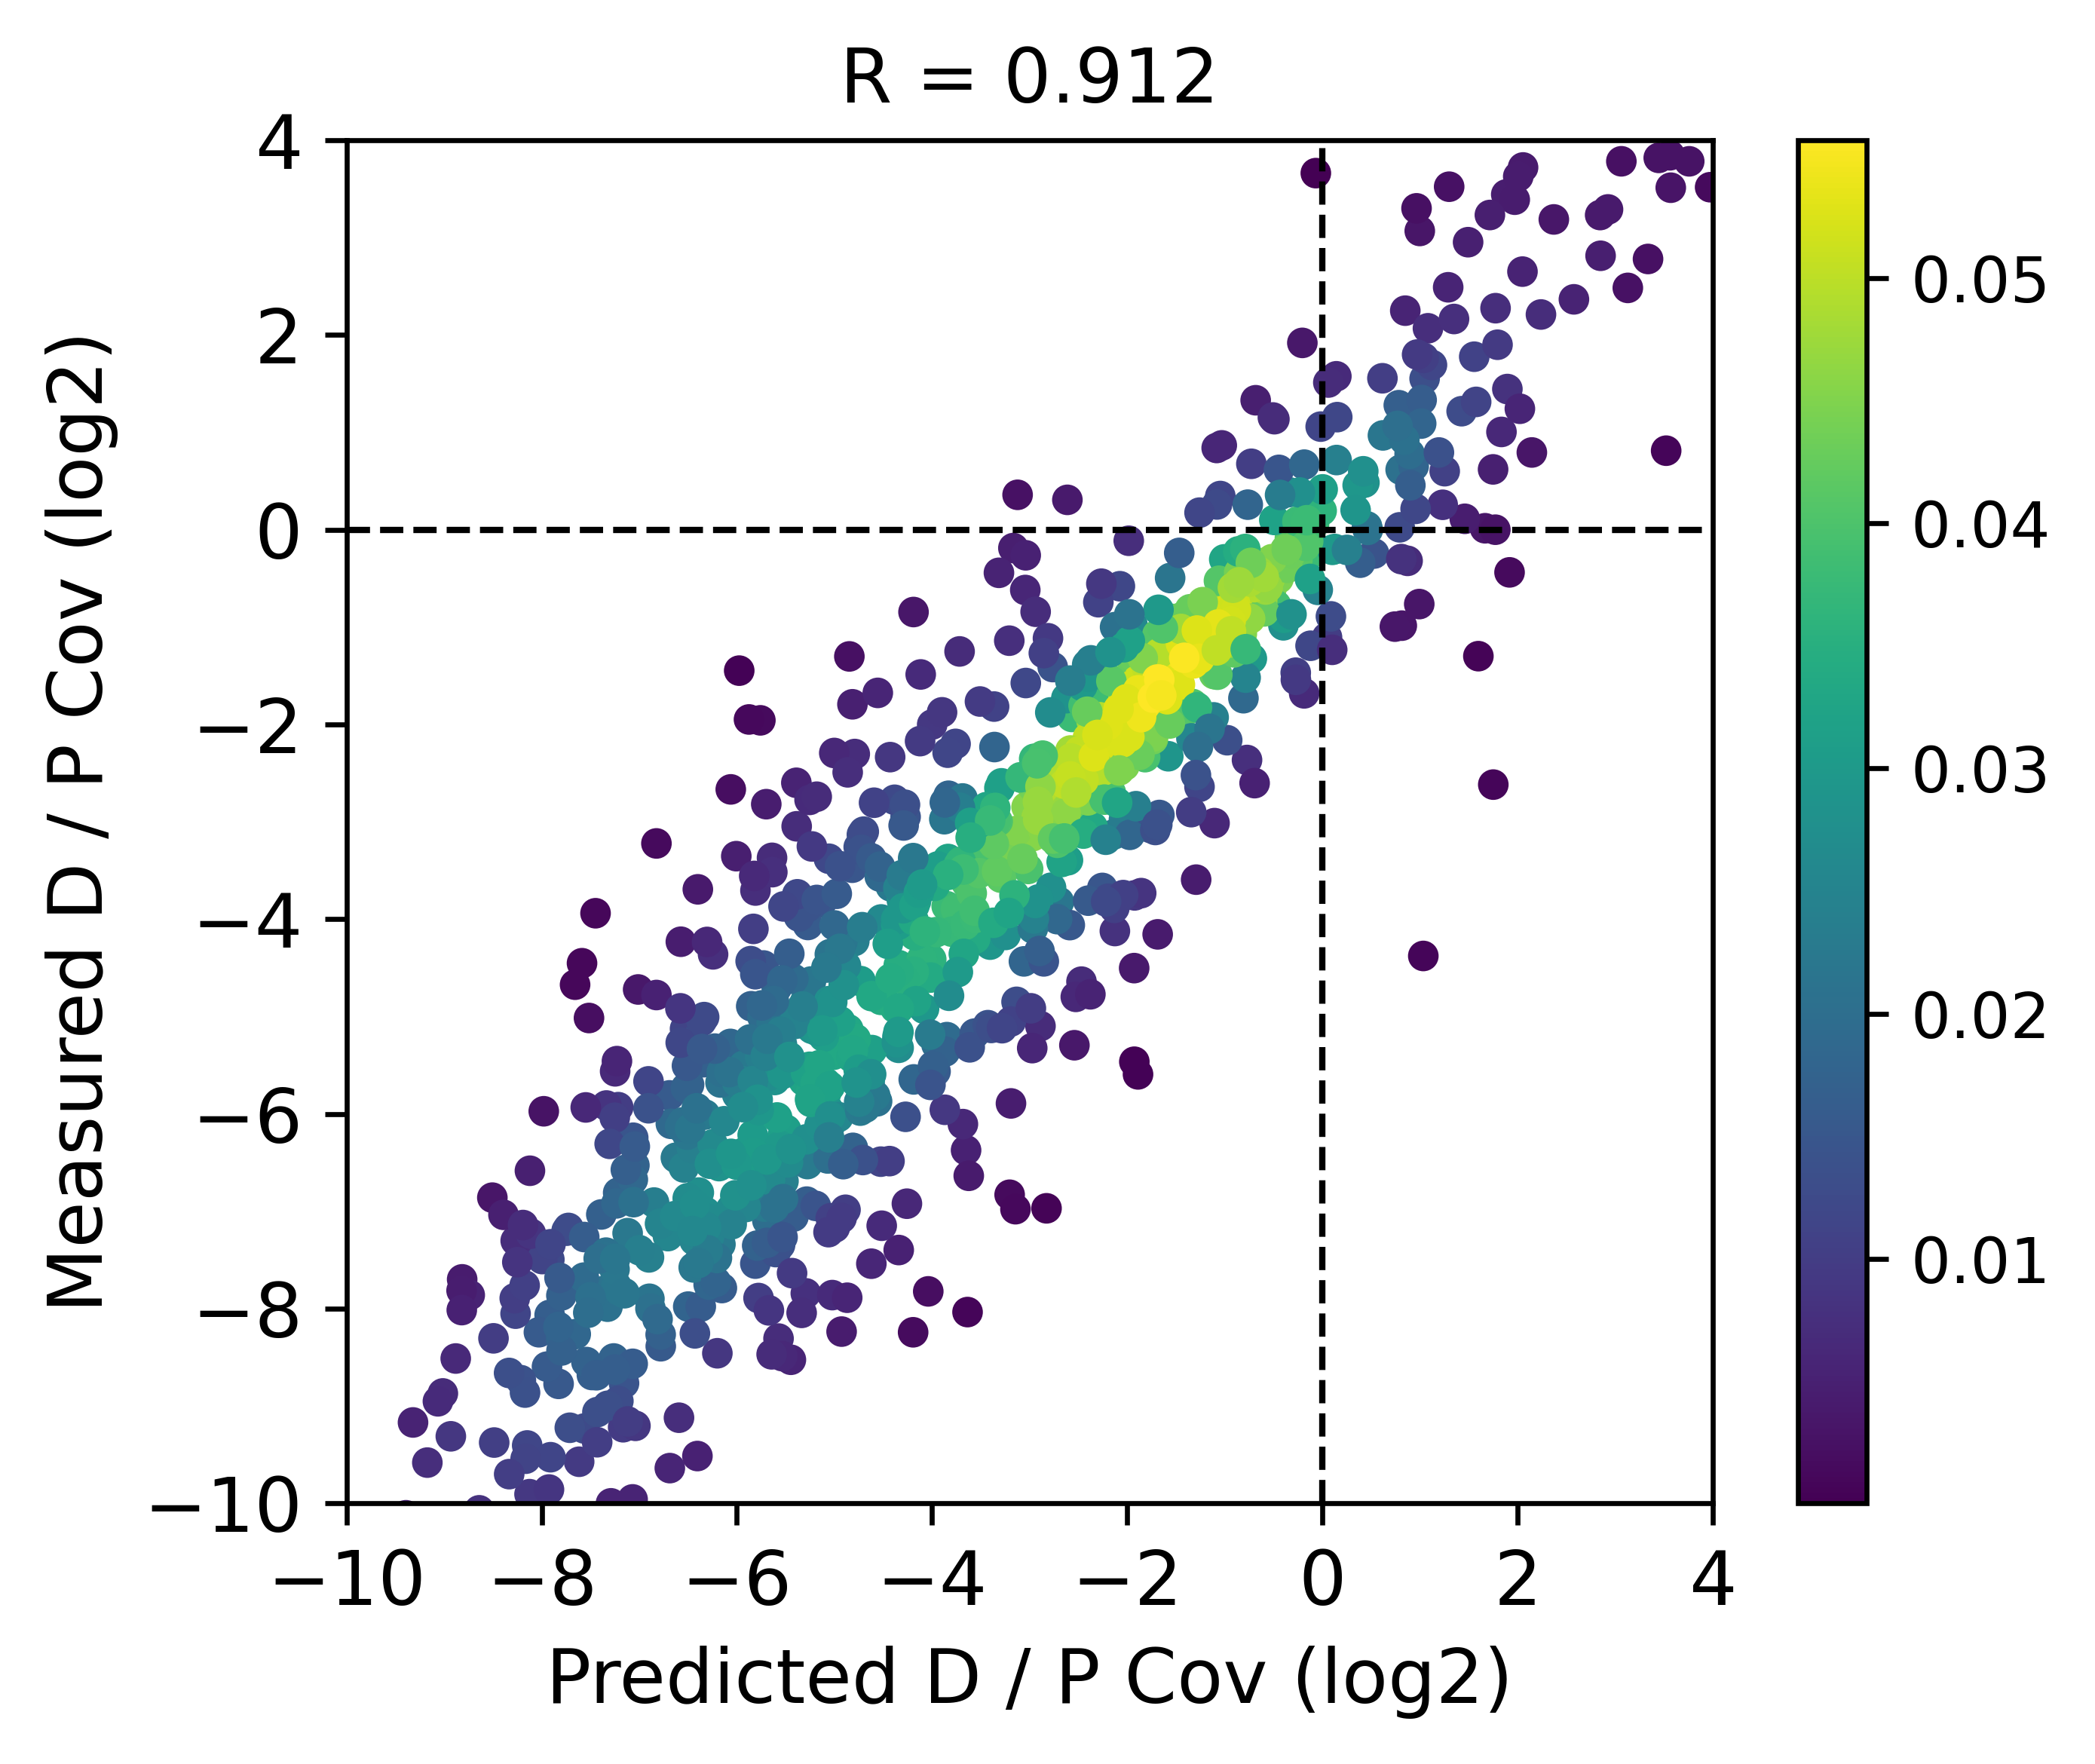

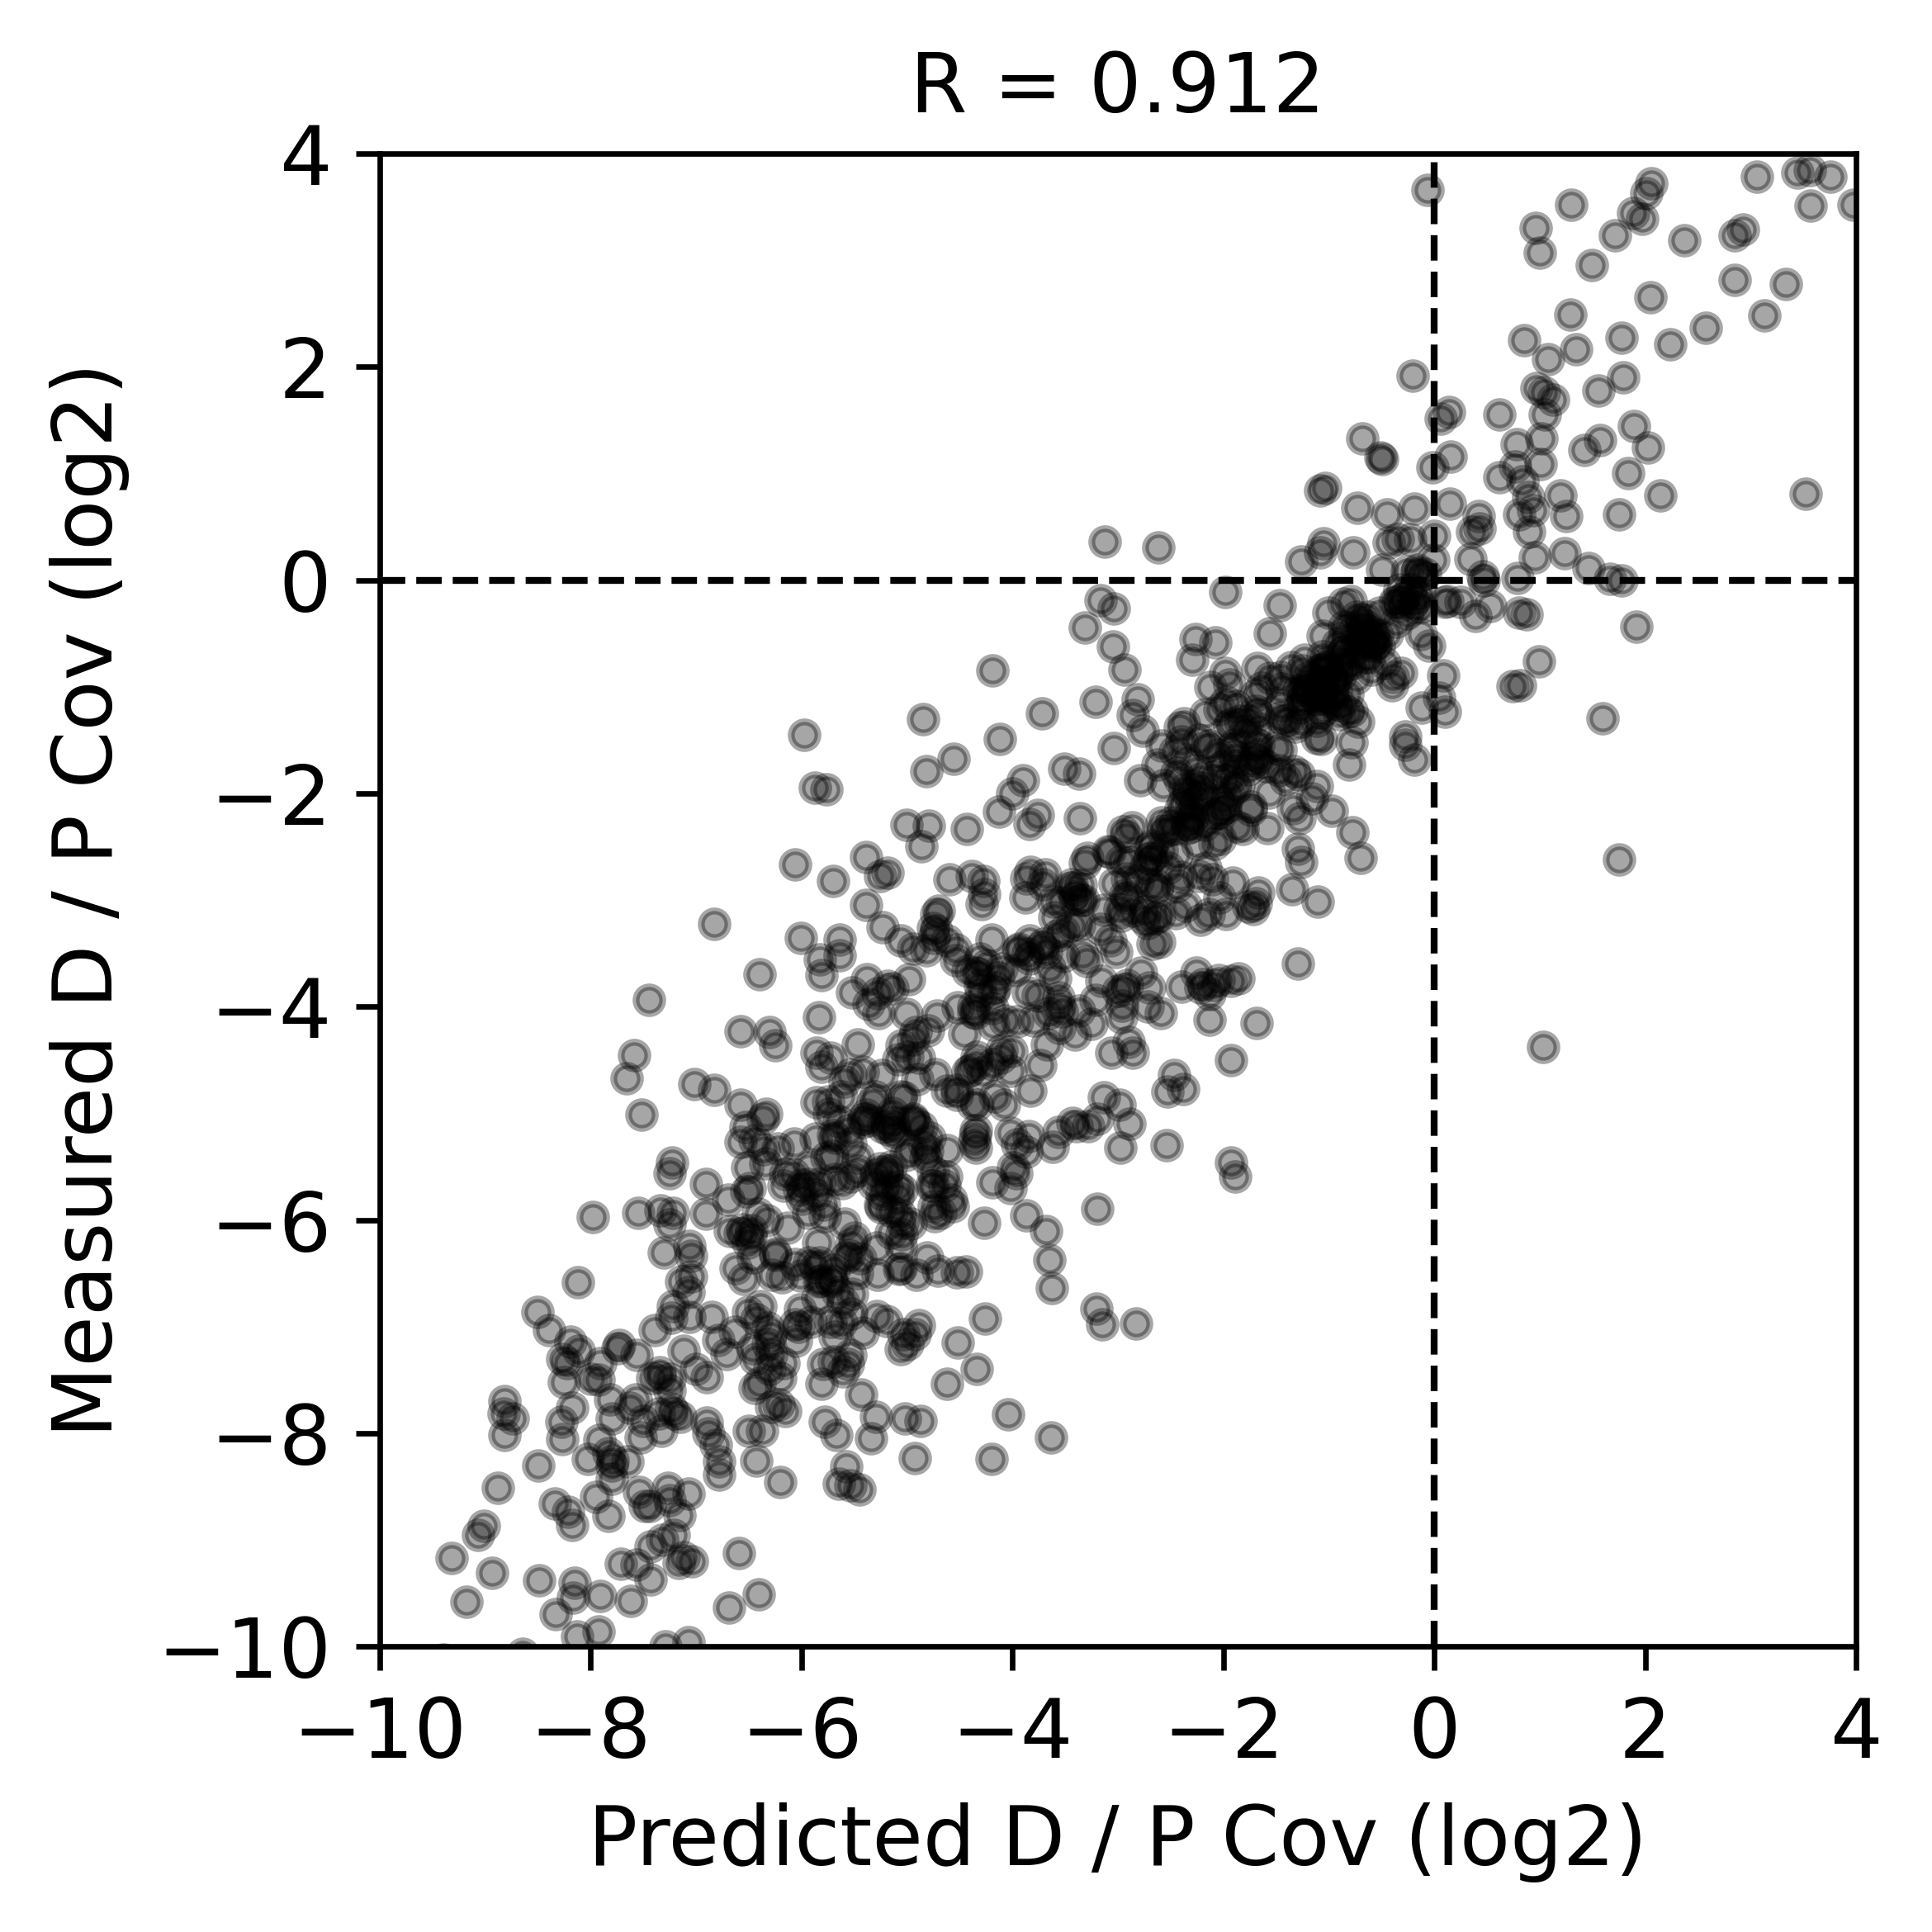

spearman r = 0.767
p = 1.4839976234870187e-181
n = 994
(pearson r = 0.752)
spearman r = 0.774
p = 7.033840321530879e-181
n = 994
(pearson r = 0.751)


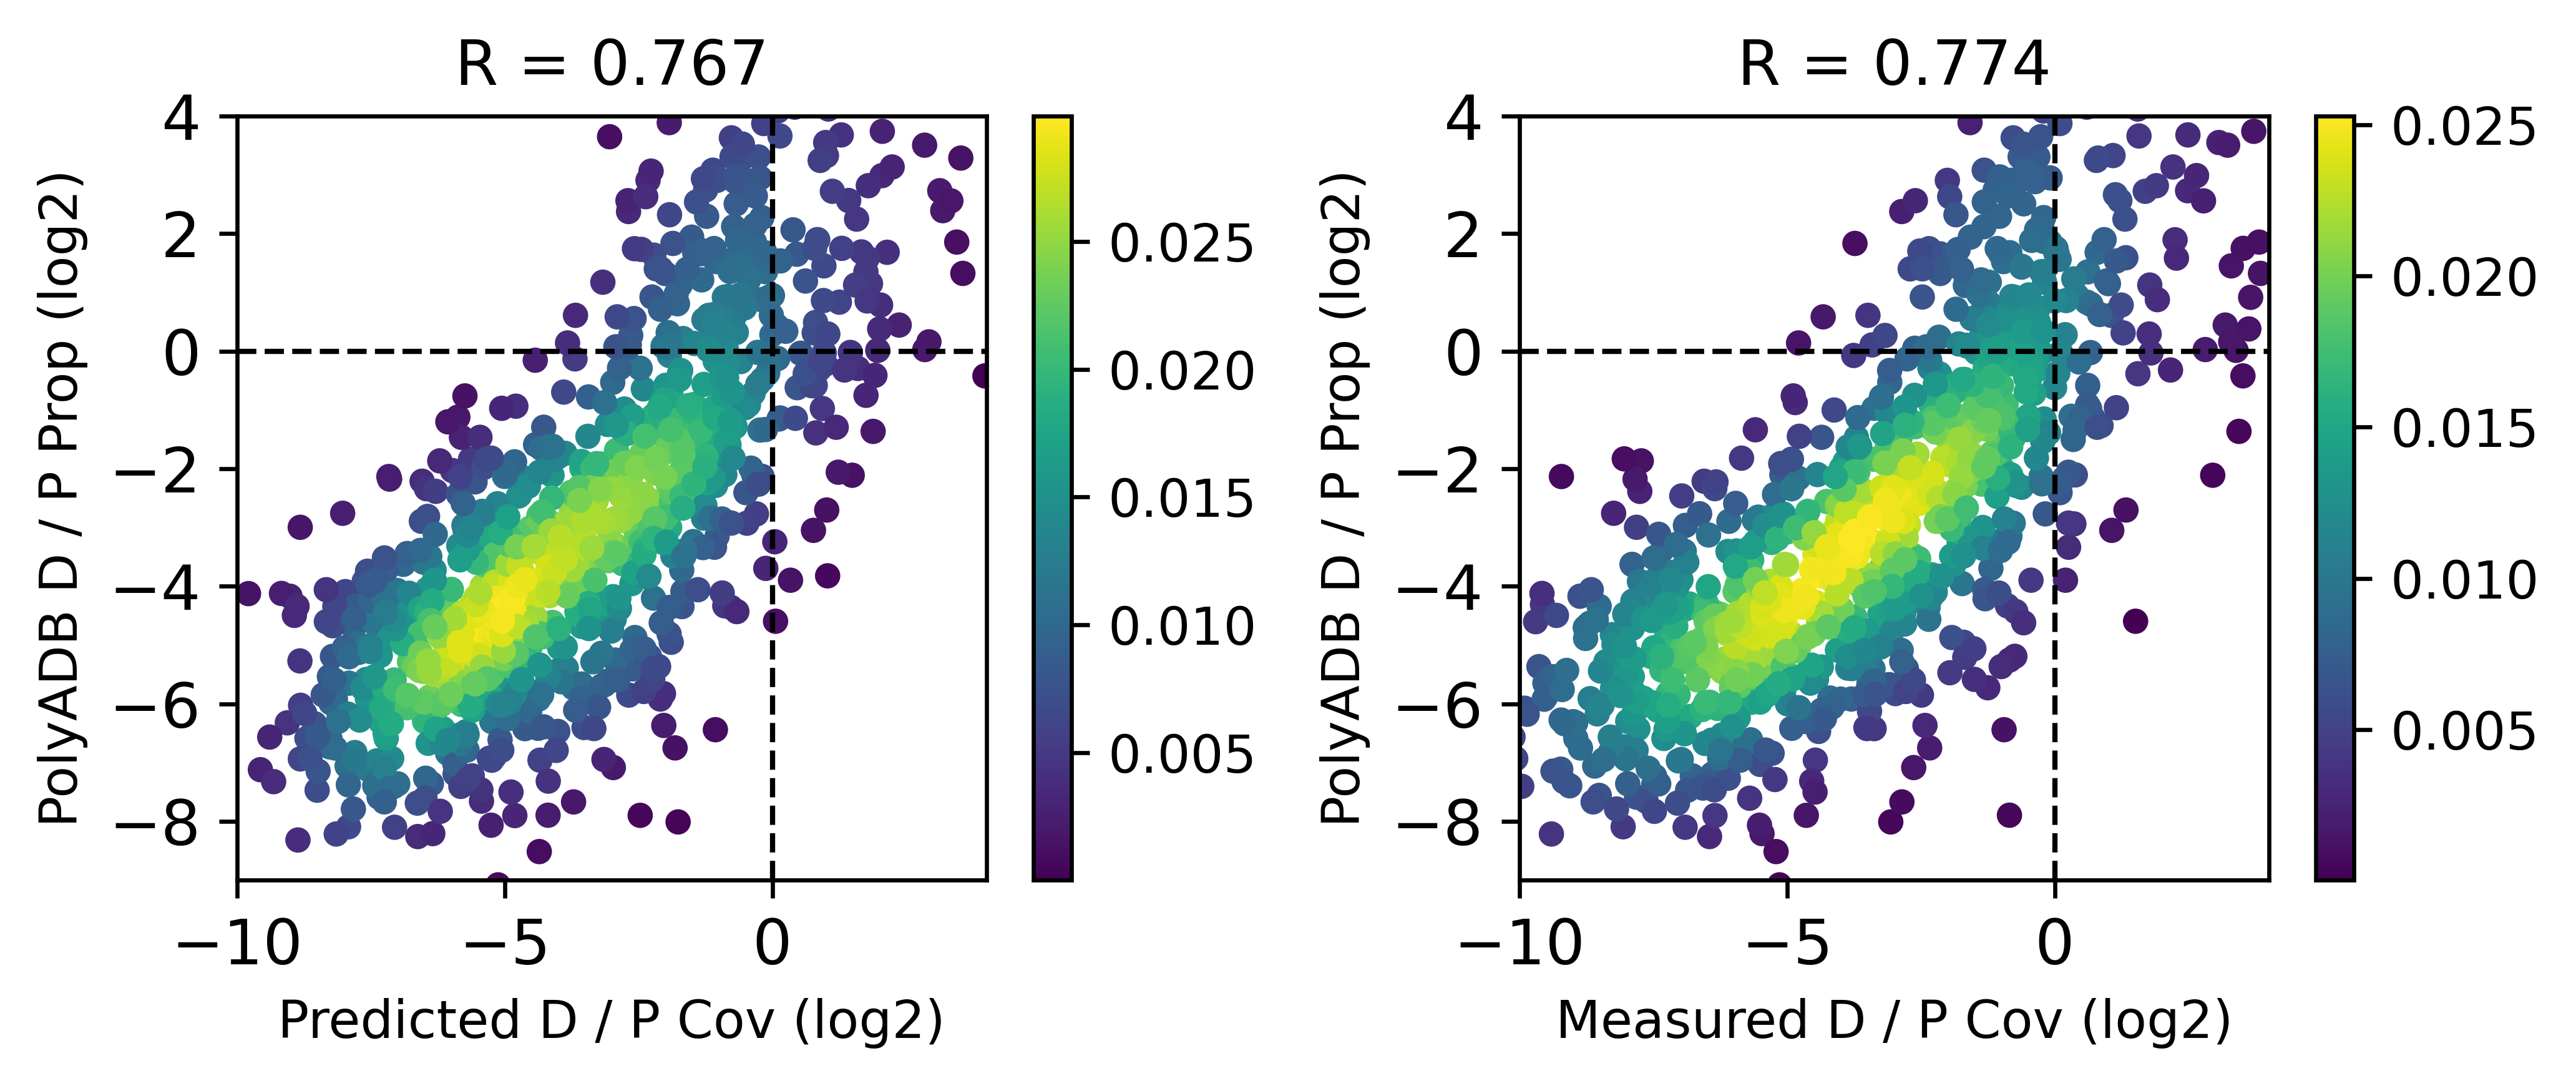

In [8]:
#Evaluate test set performance on held-out genes (tissue-pooled)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import spearmanr, pearsonr, gaussian_kde

fold_ix = 3
cross_index = [0, 1, 2, 3]

save_figs = True
save_suffix = '_apa_rna3_gencode_5_tissues_w_bar'

n_kde_sample = 500
plot_with_kde_bar = True

#Evaluate for fold (ensemble)

print("Evaluating for fold = " + str(fold_ix))

test_df = apa_df.loc[(~apa_df['test_fold'].isnull()) & (apa_df['test_fold'] == 'f' + str(fold_ix))].copy().reset_index(drop=True)

#Re-sort
test_df['sort_order'] = test_df['position_hg38']
test_df.loc[test_df['strand'] == '-', 'sort_order'] = -test_df.loc[test_df['strand'] == '-']['position_hg38']
test_df = test_df.sort_values(by=['gene', 'sort_order']).copy().reset_index(drop=True)

#Pool predictions / measurements across tissues or cell types
test_df['cov_pred'] = 0.
test_df['cov_true'] = 0.
for tissue in tissues :
    if '_other' not in tissue :
        test_df['cov_pred'] += test_df[tissue + '_pred']
        test_df['cov_true'] += test_df[tissue + '_true']

#Aggregate gene-level statistics from APA dataframe (distal usage proportions, etc.)
gene_df = test_df.groupby(['gene']).agg({
    'exon_overlap' : ['first', 'last'],
    'antisense_overlap' : ['first', 'last'],
    'strand' : ['first', 'last'],
    'position_hg38' : ['first', 'last'],
    'total_count' : ['count', 'sum', 'first', 'last'],
    'cov_pred' : ['sum', 'first', 'last', 'count'],
    'cov_true' : ['sum', 'first', 'last']
})

gene_df.columns = ['_'.join(col).strip() for col in gene_df.columns.values]

gene_df = gene_df.reset_index().copy()

gene_df = gene_df.rename(columns={
    'exon_overlap_first' :  'prox_exon_overlap',
    'antisense_overlap_first' :  'prox_antisense_overlap',
    'exon_overlap_last' :  'dist_exon_overlap',
    'antisense_overlap_last' :  'dist_antisense_overlap',
    'strand_first' :  'strand',
    'position_hg38_first' : 'prox_pos',
    'position_hg38_last' : 'dist_pos',
    'total_count_sum' : 'total_count',
    'total_count_first' : 'prox_count',
    'total_count_last' : 'dist_count',
    'cov_pred_first' : 'prox_cov_pred',
    'cov_pred_last' : 'dist_cov_pred',
    'cov_pred_sum' : 'total_cov_pred',
    'cov_true_first' : 'prox_cov_true',
    'cov_true_last' : 'dist_cov_true',
    'cov_true_sum' : 'total_cov_true',
    'cov_pred_count' : 'n_sites',
})

gene_df = gene_df.query("n_sites > 1").copy().reset_index(drop=True)
gene_df = gene_df.query("prox_antisense_overlap == False and dist_antisense_overlap == False").copy().reset_index(drop=True)
gene_df = gene_df.query("(strand == '+' and dist_pos - prox_pos >= 128) or (strand == '-' and prox_pos - dist_pos >= 128)").copy().reset_index(drop=True)

gene_df['cov_ratio_pred'] = gene_df['dist_cov_pred'] / gene_df['total_cov_pred']
gene_df['cov_ratio_true'] = gene_df['dist_cov_true'] / gene_df['total_cov_true']
gene_df['dist_ratio'] = gene_df['dist_count'] / gene_df['total_count']

gene_df = gene_df.loc[~(np.isnan(gene_df['cov_ratio_pred']) | np.isinf(gene_df['cov_ratio_pred']))].copy().reset_index(drop=True)
gene_df = gene_df.loc[~(np.isnan(gene_df['cov_ratio_true']) | np.isinf(gene_df['cov_ratio_true']))].copy().reset_index(drop=True)
gene_df = gene_df.loc[~(np.isnan(gene_df['dist_ratio']) | np.isinf(gene_df['dist_ratio']))].copy().reset_index(drop=True)

#Compare predicted vs. measured Distal / Proximal coverage ratios (derived from RNA-seq tracks)

cov_pred = np.log2(gene_df['cov_ratio_pred'].values / (1. - gene_df['cov_ratio_pred'].values) + 1e-6)
cov_true = np.log2(gene_df['cov_ratio_true'].values / (1. - gene_df['cov_ratio_true'].values) + 1e-6)
has_exon_overlap = gene_df['dist_exon_overlap'].values

sample_index = np.arange(len(gene_df), dtype='int32')
np.random.shuffle(sample_index)
sample_index = sample_index[:n_kde_sample]

vals = np.concatenate([
    np.copy(cov_pred)[None, :],
    np.copy(cov_true)[None, :],
], axis=0)

gkernel = gaussian_kde(vals[:, sample_index])(vals)

rs_val, p_val = spearmanr(cov_pred, cov_true)
rp_val, p_val = pearsonr(cov_pred, cov_true)

print("spearman r = " + str(round(rs_val, 3)))
print("p = " + str(p_val))
print("n = " + str(len(gene_df)))

print("(pearson r = " + str(round(rp_val, 3)) + ")")

#Plot as density KDE
f = None
if not save_figs :
    f = plt.figure(figsize=(4.75, 4))
else :
    f = plt.figure(figsize=(4.75, 4), dpi=600)

plt.scatter(cov_pred, cov_true, s=15, c=gkernel, cmap='viridis', rasterized=True)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

if plot_with_kde_bar :
    plt.colorbar()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(-10, 4)
plt.ylim(-10, 4)

plt.xlabel("Predicted D / P Cov (log2)", fontsize=12)
plt.ylabel("Measured D / P Cov (log2)", fontsize=12)

plt.title(label="R = " + str(round(rs_val, 3)))

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v4_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.png', dpi=600)
    plt.savefig('borzoi_v4_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.pdf')

plt.show()

#Plot with separate color for non-exon-overlapping APA sites
f = None
if not save_figs :
    f = plt.figure(figsize=(4, 4))
else :
    f = plt.figure(figsize=(4, 4), dpi=600)

plt.scatter(cov_pred, cov_true, s=15, alpha=0.35, c='black', rasterized=True)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(-10, 4)
plt.ylim(-10, 4)

plt.xlabel("Predicted D / P Cov (log2)", fontsize=12)
plt.ylabel("Measured D / P Cov (log2)", fontsize=12)

plt.title("R = " + str(round(rs_val, 3)), fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v4_cov' + save_suffix + '_fold_' + str(fold_ix) + '_scatter.png', dpi=600)
    plt.savefig('borzoi_v4_cov' + save_suffix + '_fold_' + str(fold_ix) + '_scatter.pdf')

plt.show()

#Compare predicted (or measured) distal / proximal coverage ratio (derived from RNA-seq) against distal / proximal isoform proportions (derived from 3'-seq)
f, ax = None, None
if not save_figs :
    f, ax = plt.subplots(1, 2, figsize=(7, 3))
else :
    f, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=600)

plt.sca(ax[0])

#Predicted coverage
cov_pred = np.log2(gene_df['cov_ratio_pred'].values / (1. - gene_df['cov_ratio_pred'].values) + 1e-6)
cov_true = np.log2(gene_df['dist_ratio'].values / (1. - gene_df['dist_ratio'].values) + 1e-6)

vals = np.concatenate([
    np.copy(cov_pred)[None, :],
    np.copy(cov_true)[None, :],
], axis=0)

gkernel = gaussian_kde(vals[:, sample_index])(vals)

rs_val, p_val = spearmanr(cov_pred, cov_true)
rp_val, p_val = pearsonr(cov_pred, cov_true)

print("spearman r = " + str(round(rs_val, 3)))
print("p = " + str(p_val))
print("n = " + str(len(gene_df)))

print("(pearson r = " + str(round(rp_val, 3)) + ")")

#Plot as density KDE
plt.scatter(cov_pred, cov_true, s=15, c=gkernel, cmap='viridis', rasterized=True)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

if plot_with_kde_bar :
    plt.colorbar()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(-10, 4)
plt.ylim(-9, 4)

plt.xlabel("Predicted D / P Cov (log2)", fontsize=10)
plt.ylabel("PolyADB D / P Prop (log2)", fontsize=10)

plt.title("R = " + str(round(rs_val, 3)), fontsize=12)

plt.sca(ax[1])

#Measured coverage
cov_pred = np.log2(gene_df['cov_ratio_true'].values / (1. - gene_df['cov_ratio_true'].values) + 1e-6)
cov_true = np.log2(gene_df['dist_ratio'].values / (1. - gene_df['dist_ratio'].values) + 1e-6)

vals = np.concatenate([
    np.copy(cov_pred)[None, :],
    np.copy(cov_true)[None, :],
], axis=0)

gkernel = gaussian_kde(vals[:, sample_index])(vals)

rs_val, p_val = spearmanr(cov_pred, cov_true)
rp_val, p_val = pearsonr(cov_pred, cov_true)

print("spearman r = " + str(round(rs_val, 3)))
print("p = " + str(p_val))
print("n = " + str(len(gene_df)))

print("(pearson r = " + str(round(rp_val, 3)) + ")")

#Plot as density KDE
plt.scatter(cov_pred, cov_true, s=15, c=gkernel, cmap='viridis', rasterized=True)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

if plot_with_kde_bar :
    plt.colorbar()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(-10, 4)
plt.ylim(-9, 4)

plt.xlabel("Measured D / P Cov (log2)", fontsize=10)
plt.ylabel("PolyADB D / P Prop (log2)", fontsize=10)

plt.title("R = " + str(round(rs_val, 3)), fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v4_cov' + save_suffix + '_fold_' + str(fold_ix) + '_polyadb_kde.png', dpi=600)
    plt.savefig('borzoi_v4_cov' + save_suffix + '_fold_' + str(fold_ix) + '_polyadb_kde.pdf')

plt.show()


Evaluating for fold = 3
spearman r = 0.546
p = 1.5223321312161847e-94
n = 994
(pearson r = 0.591)


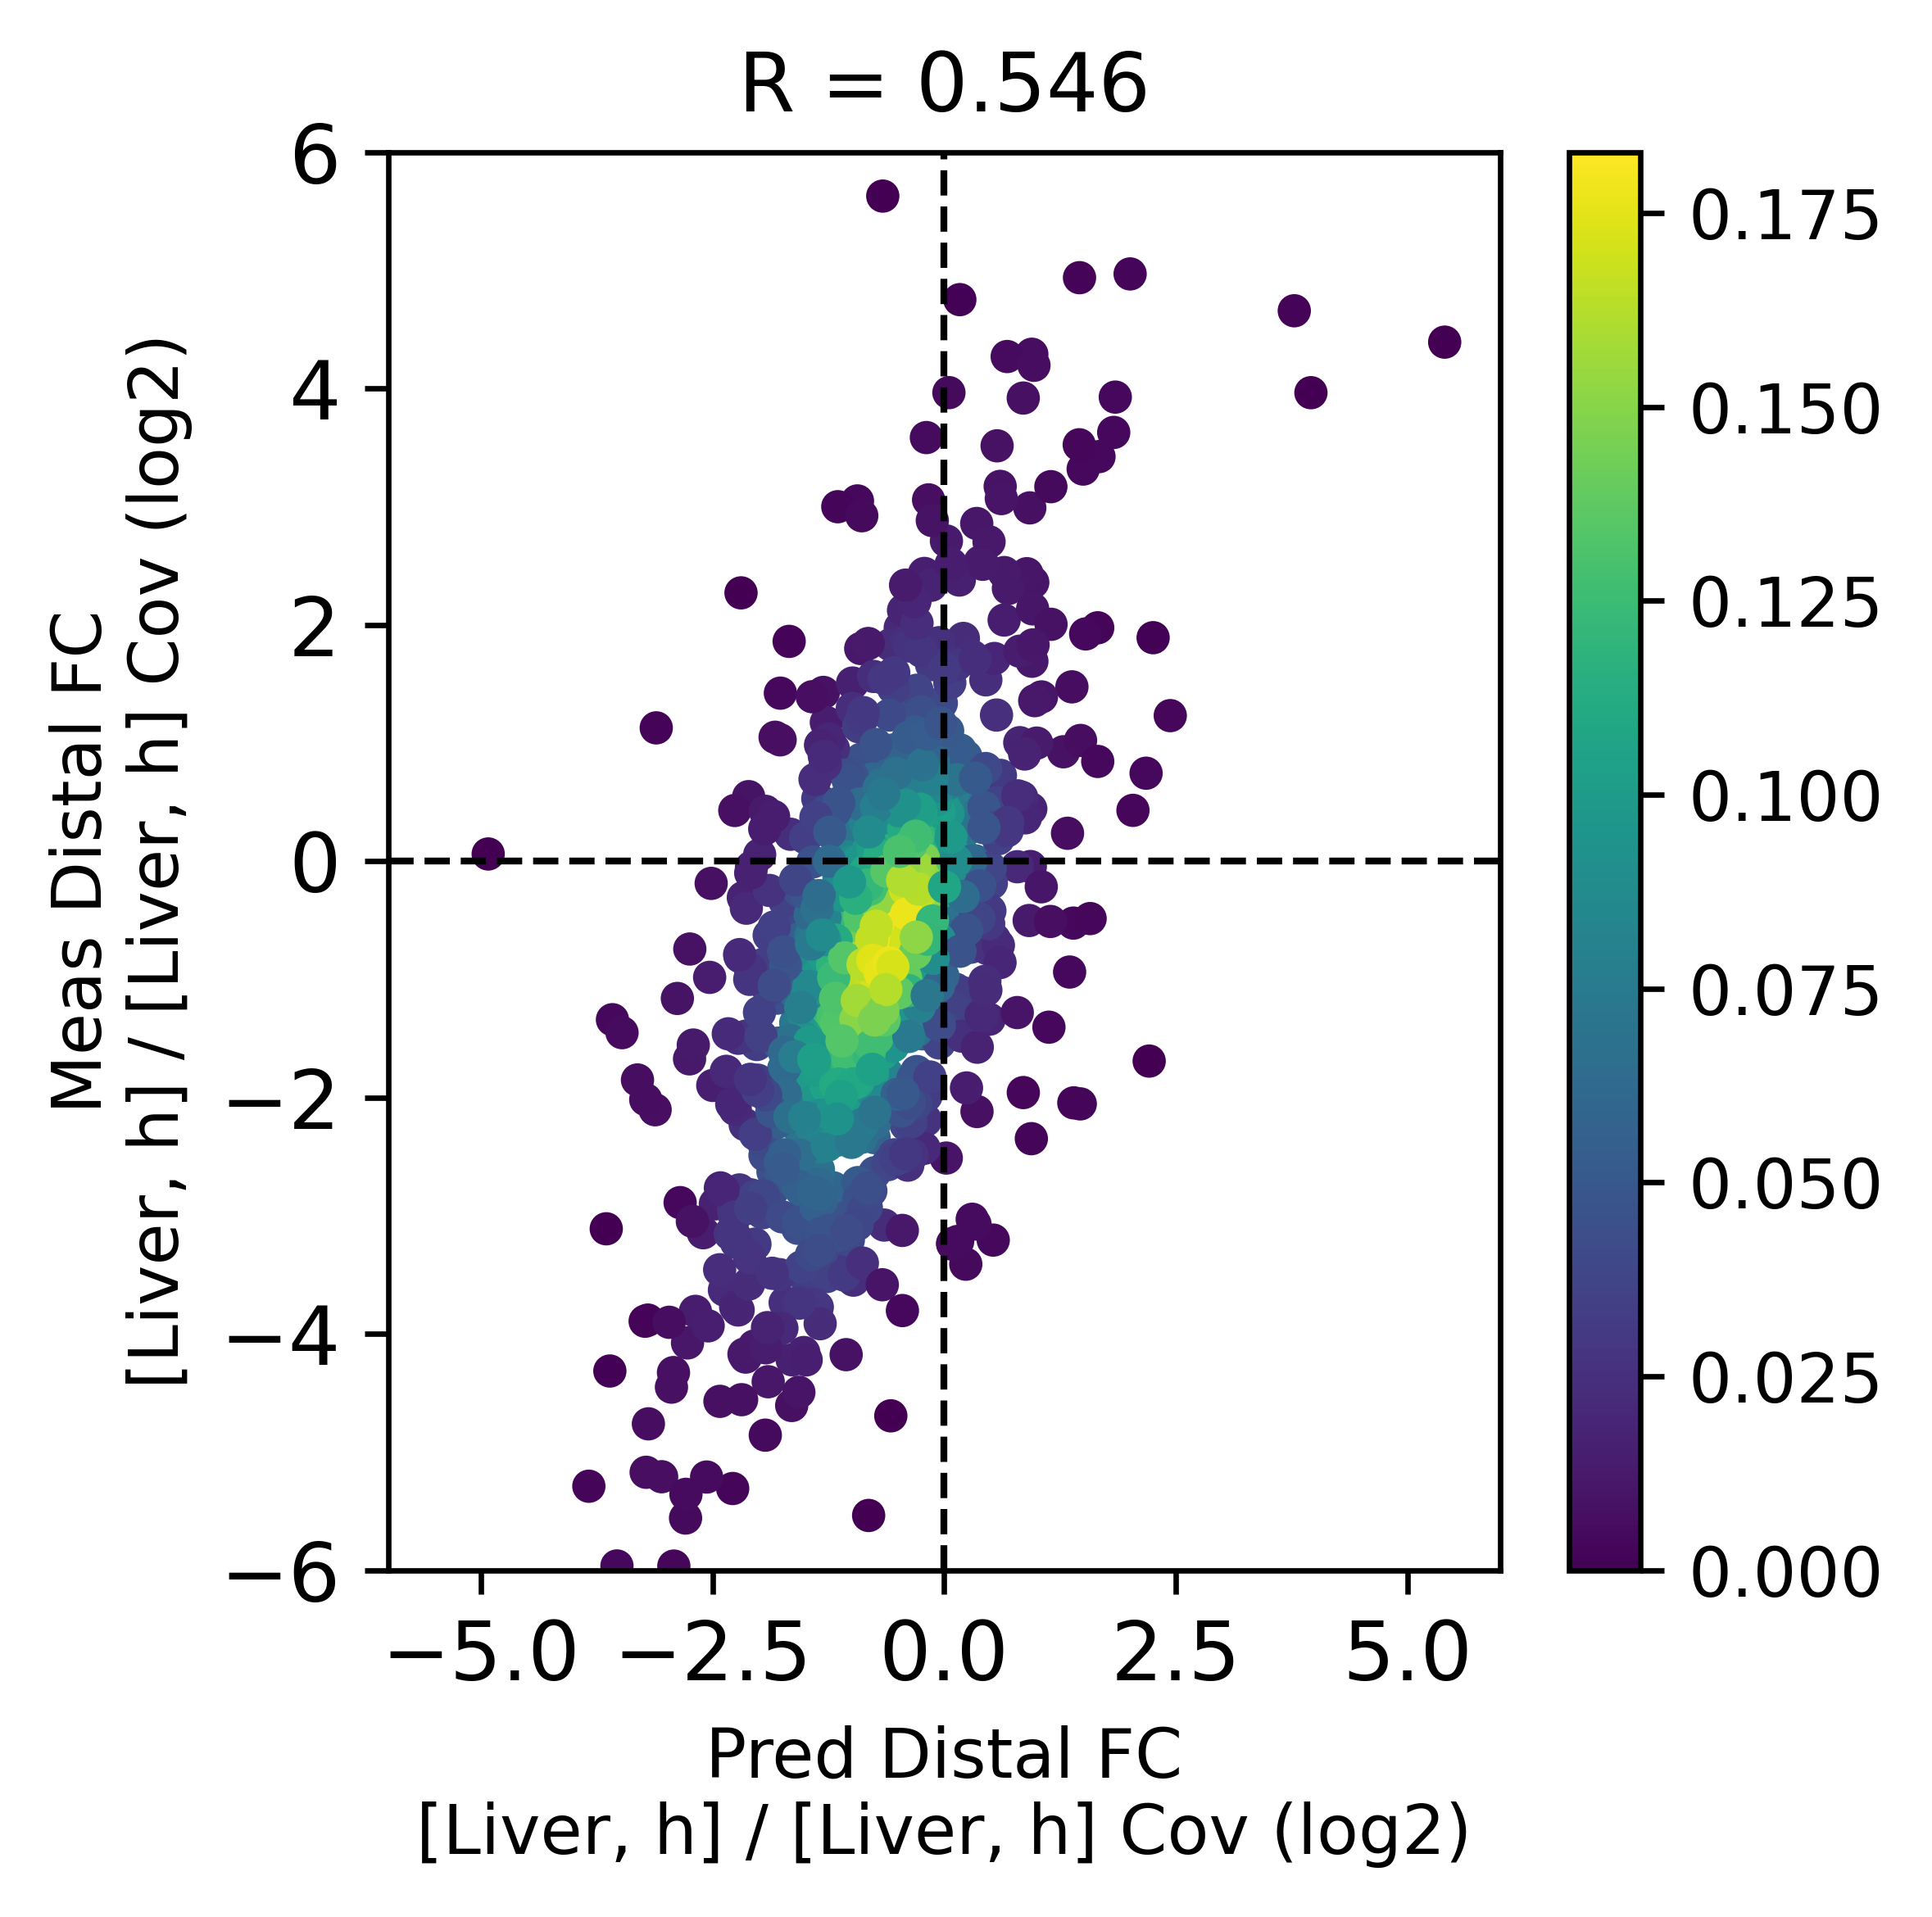

spearman r = 0.545
p = 7.642903559217386e-102
n = 994
(pearson r = 0.609)


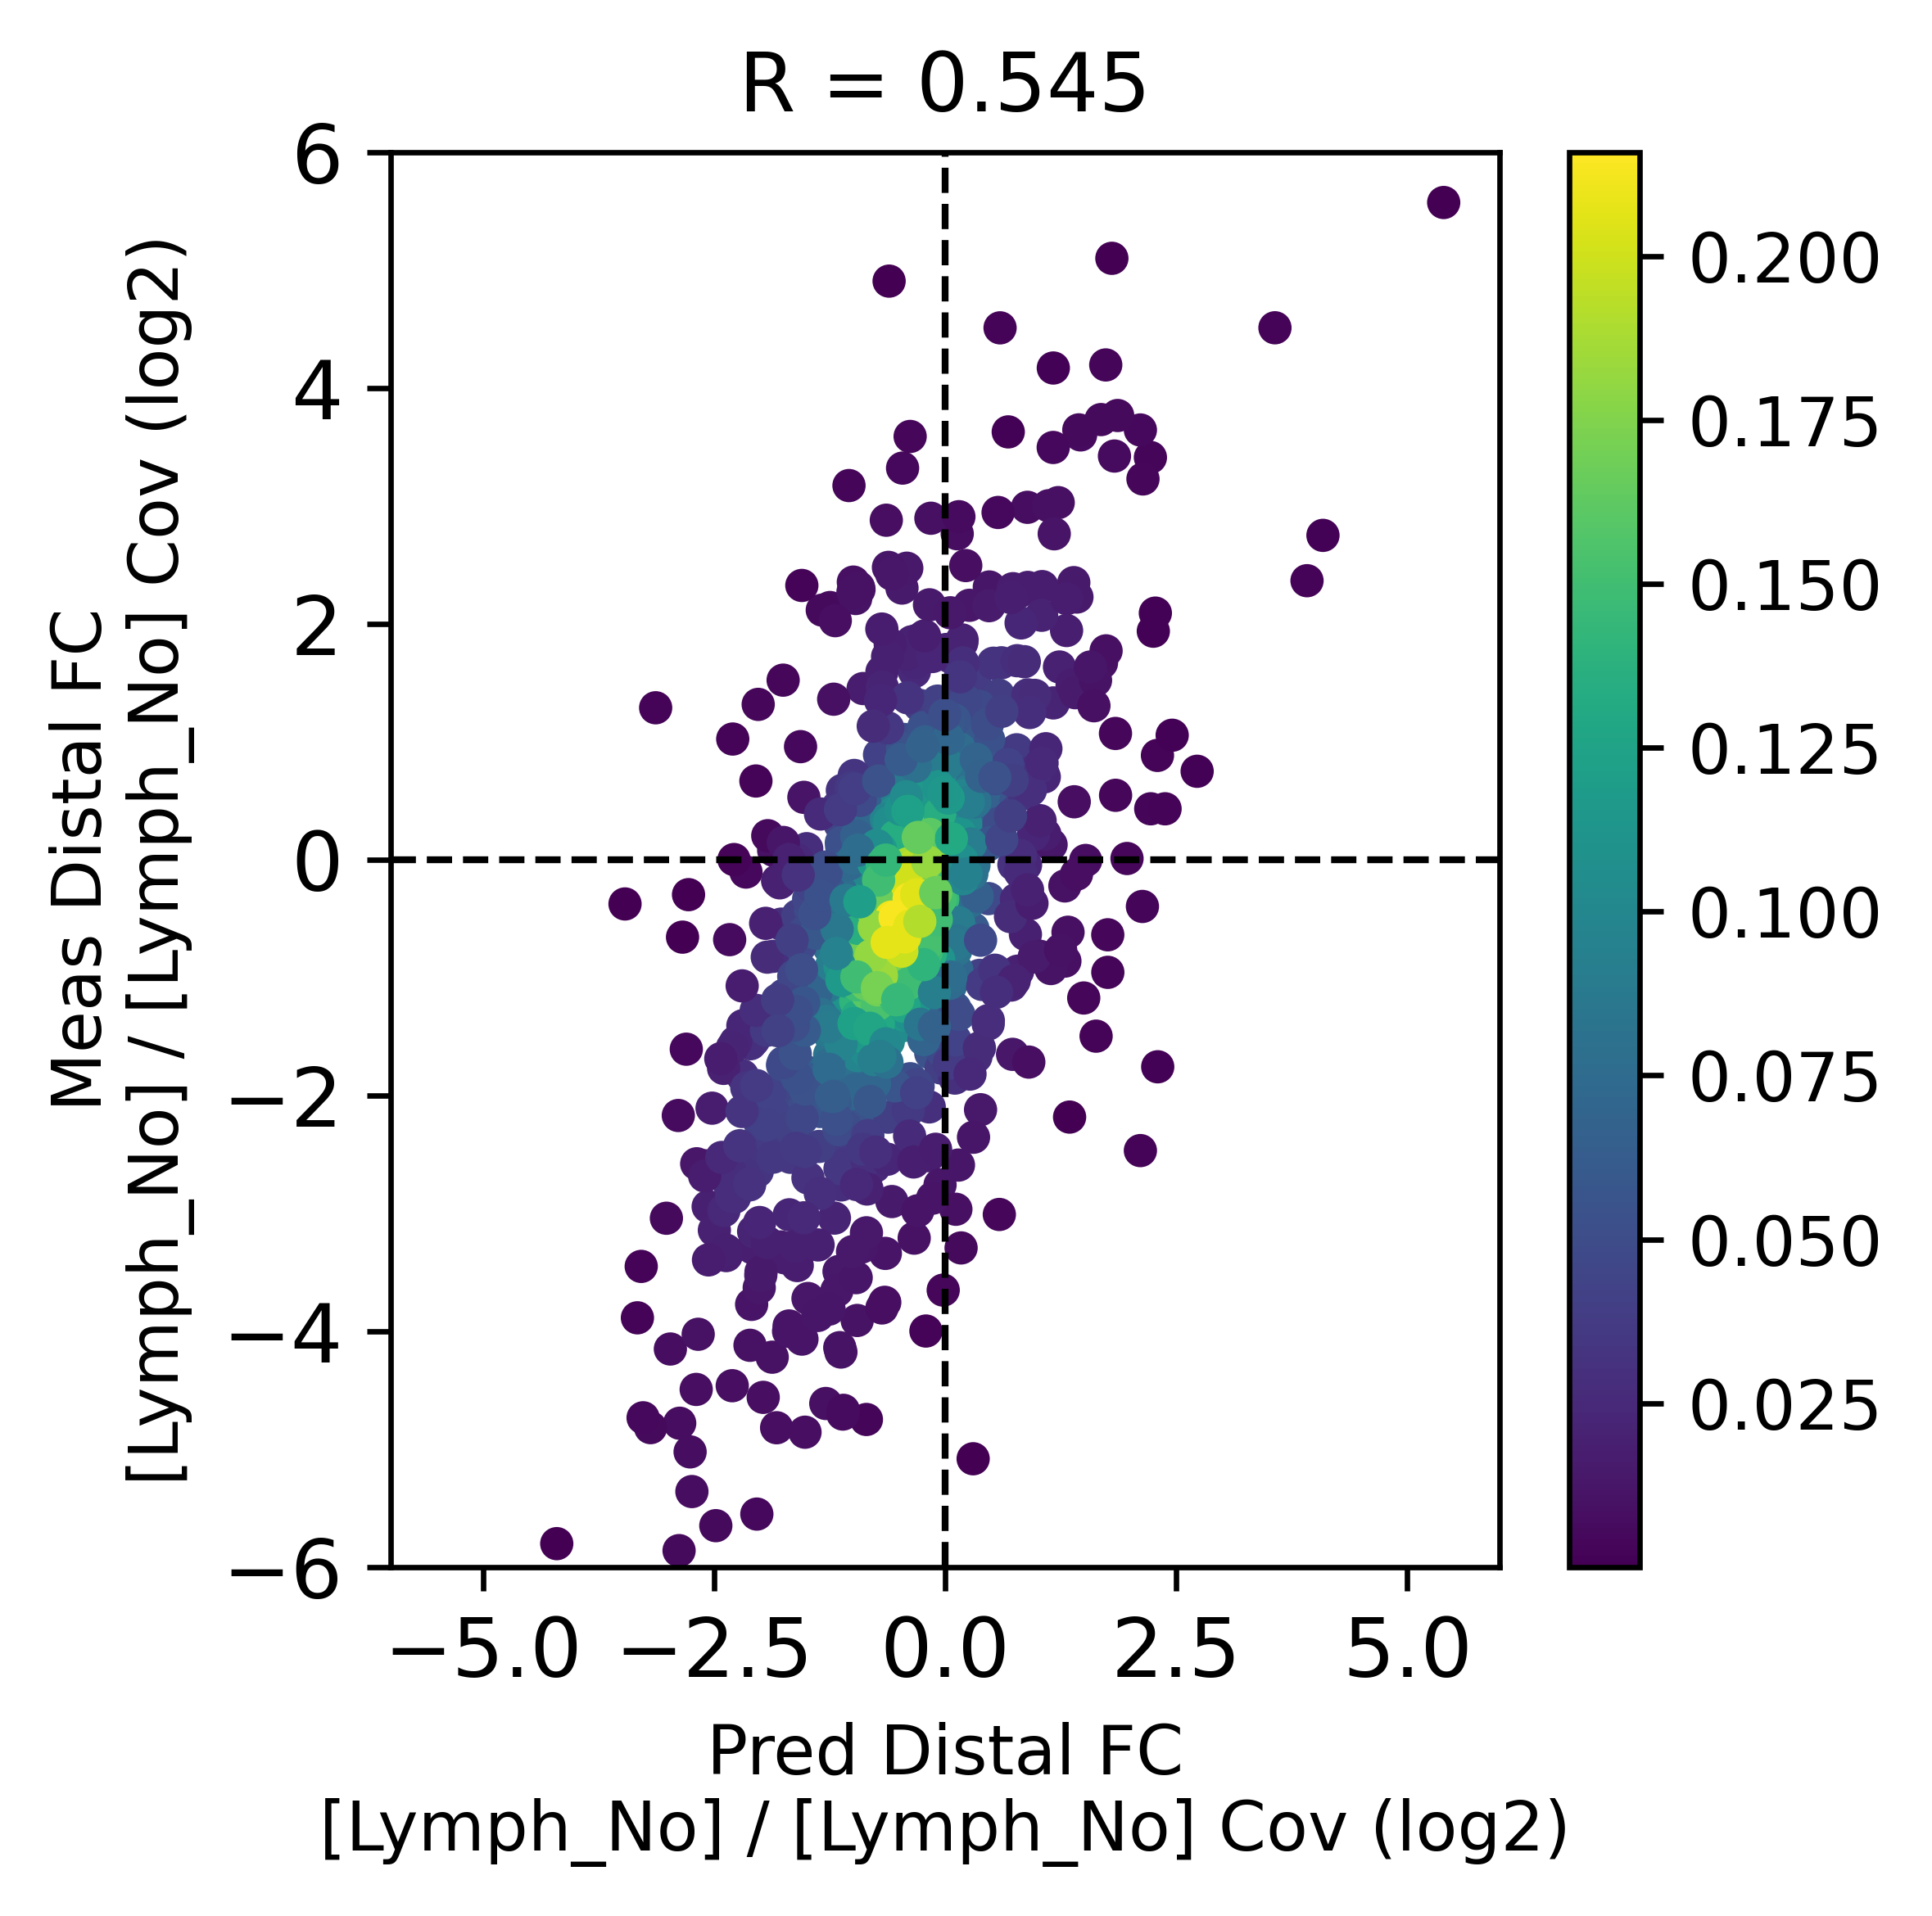

spearman r = 0.541
p = 2.675676011238953e-88
n = 994
(pearson r = 0.574)


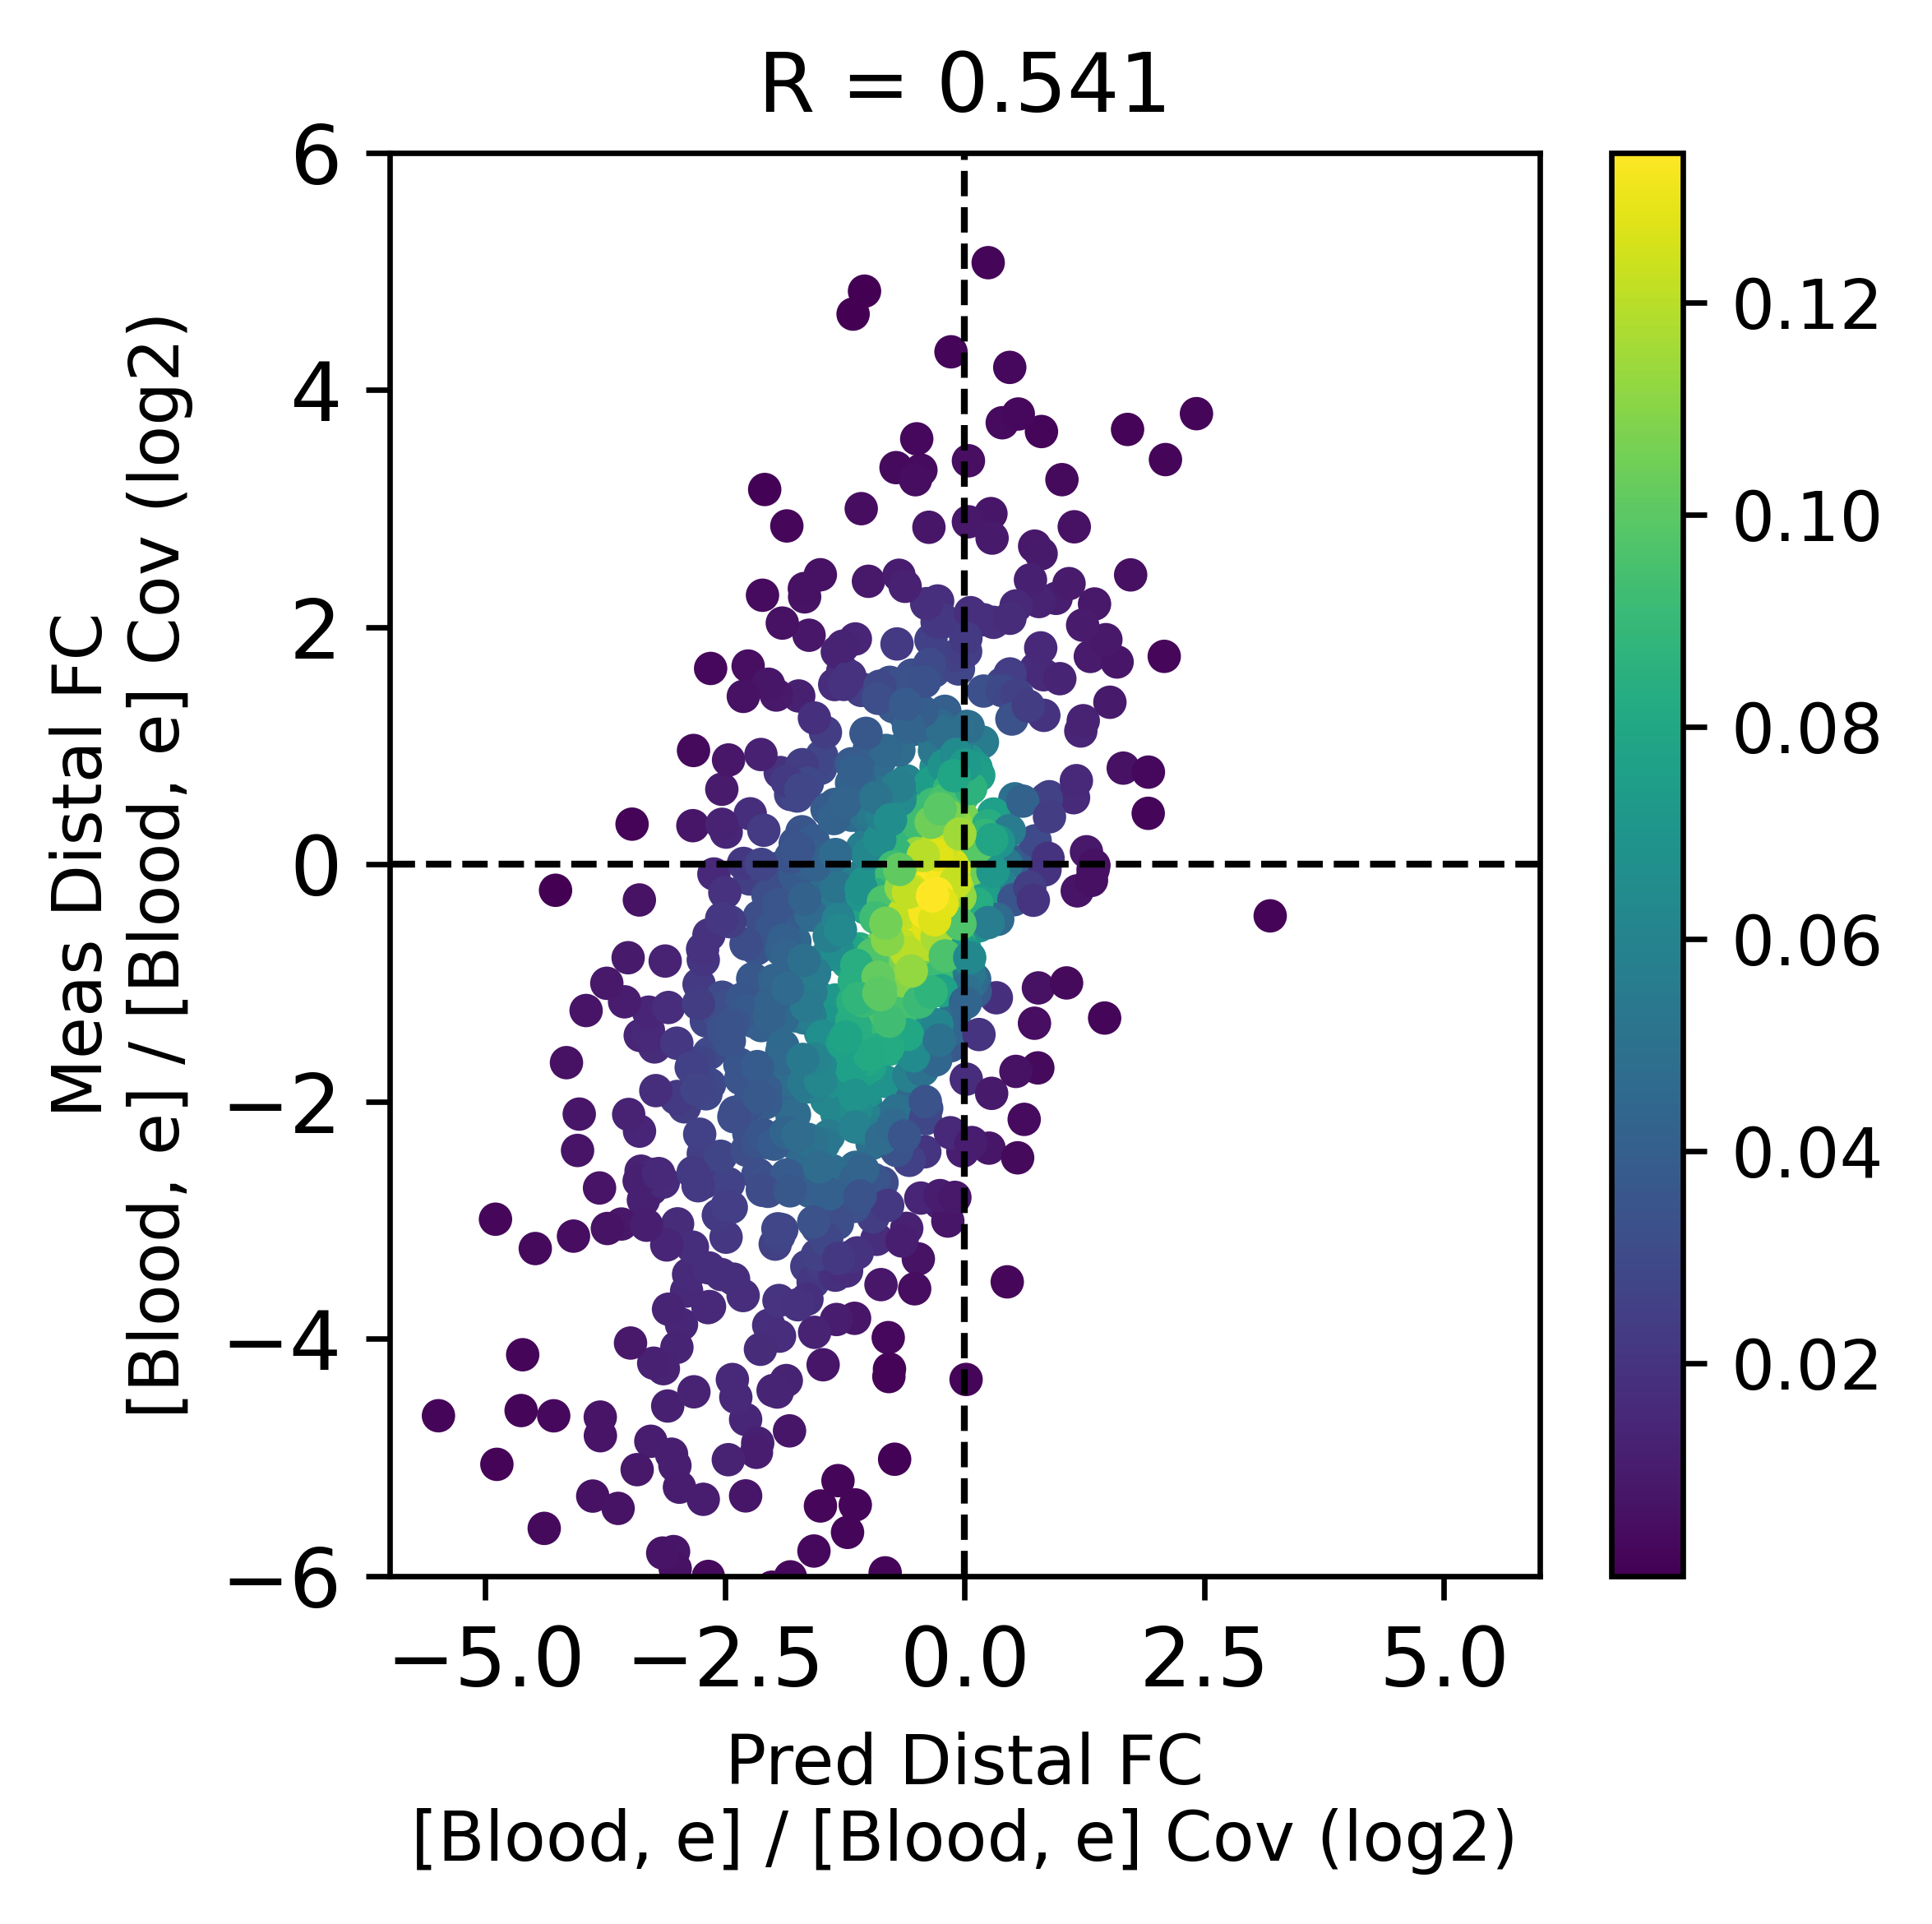

spearman r = 0.57
p = 3.4266712784199576e-100
n = 994
(pearson r = 0.605)


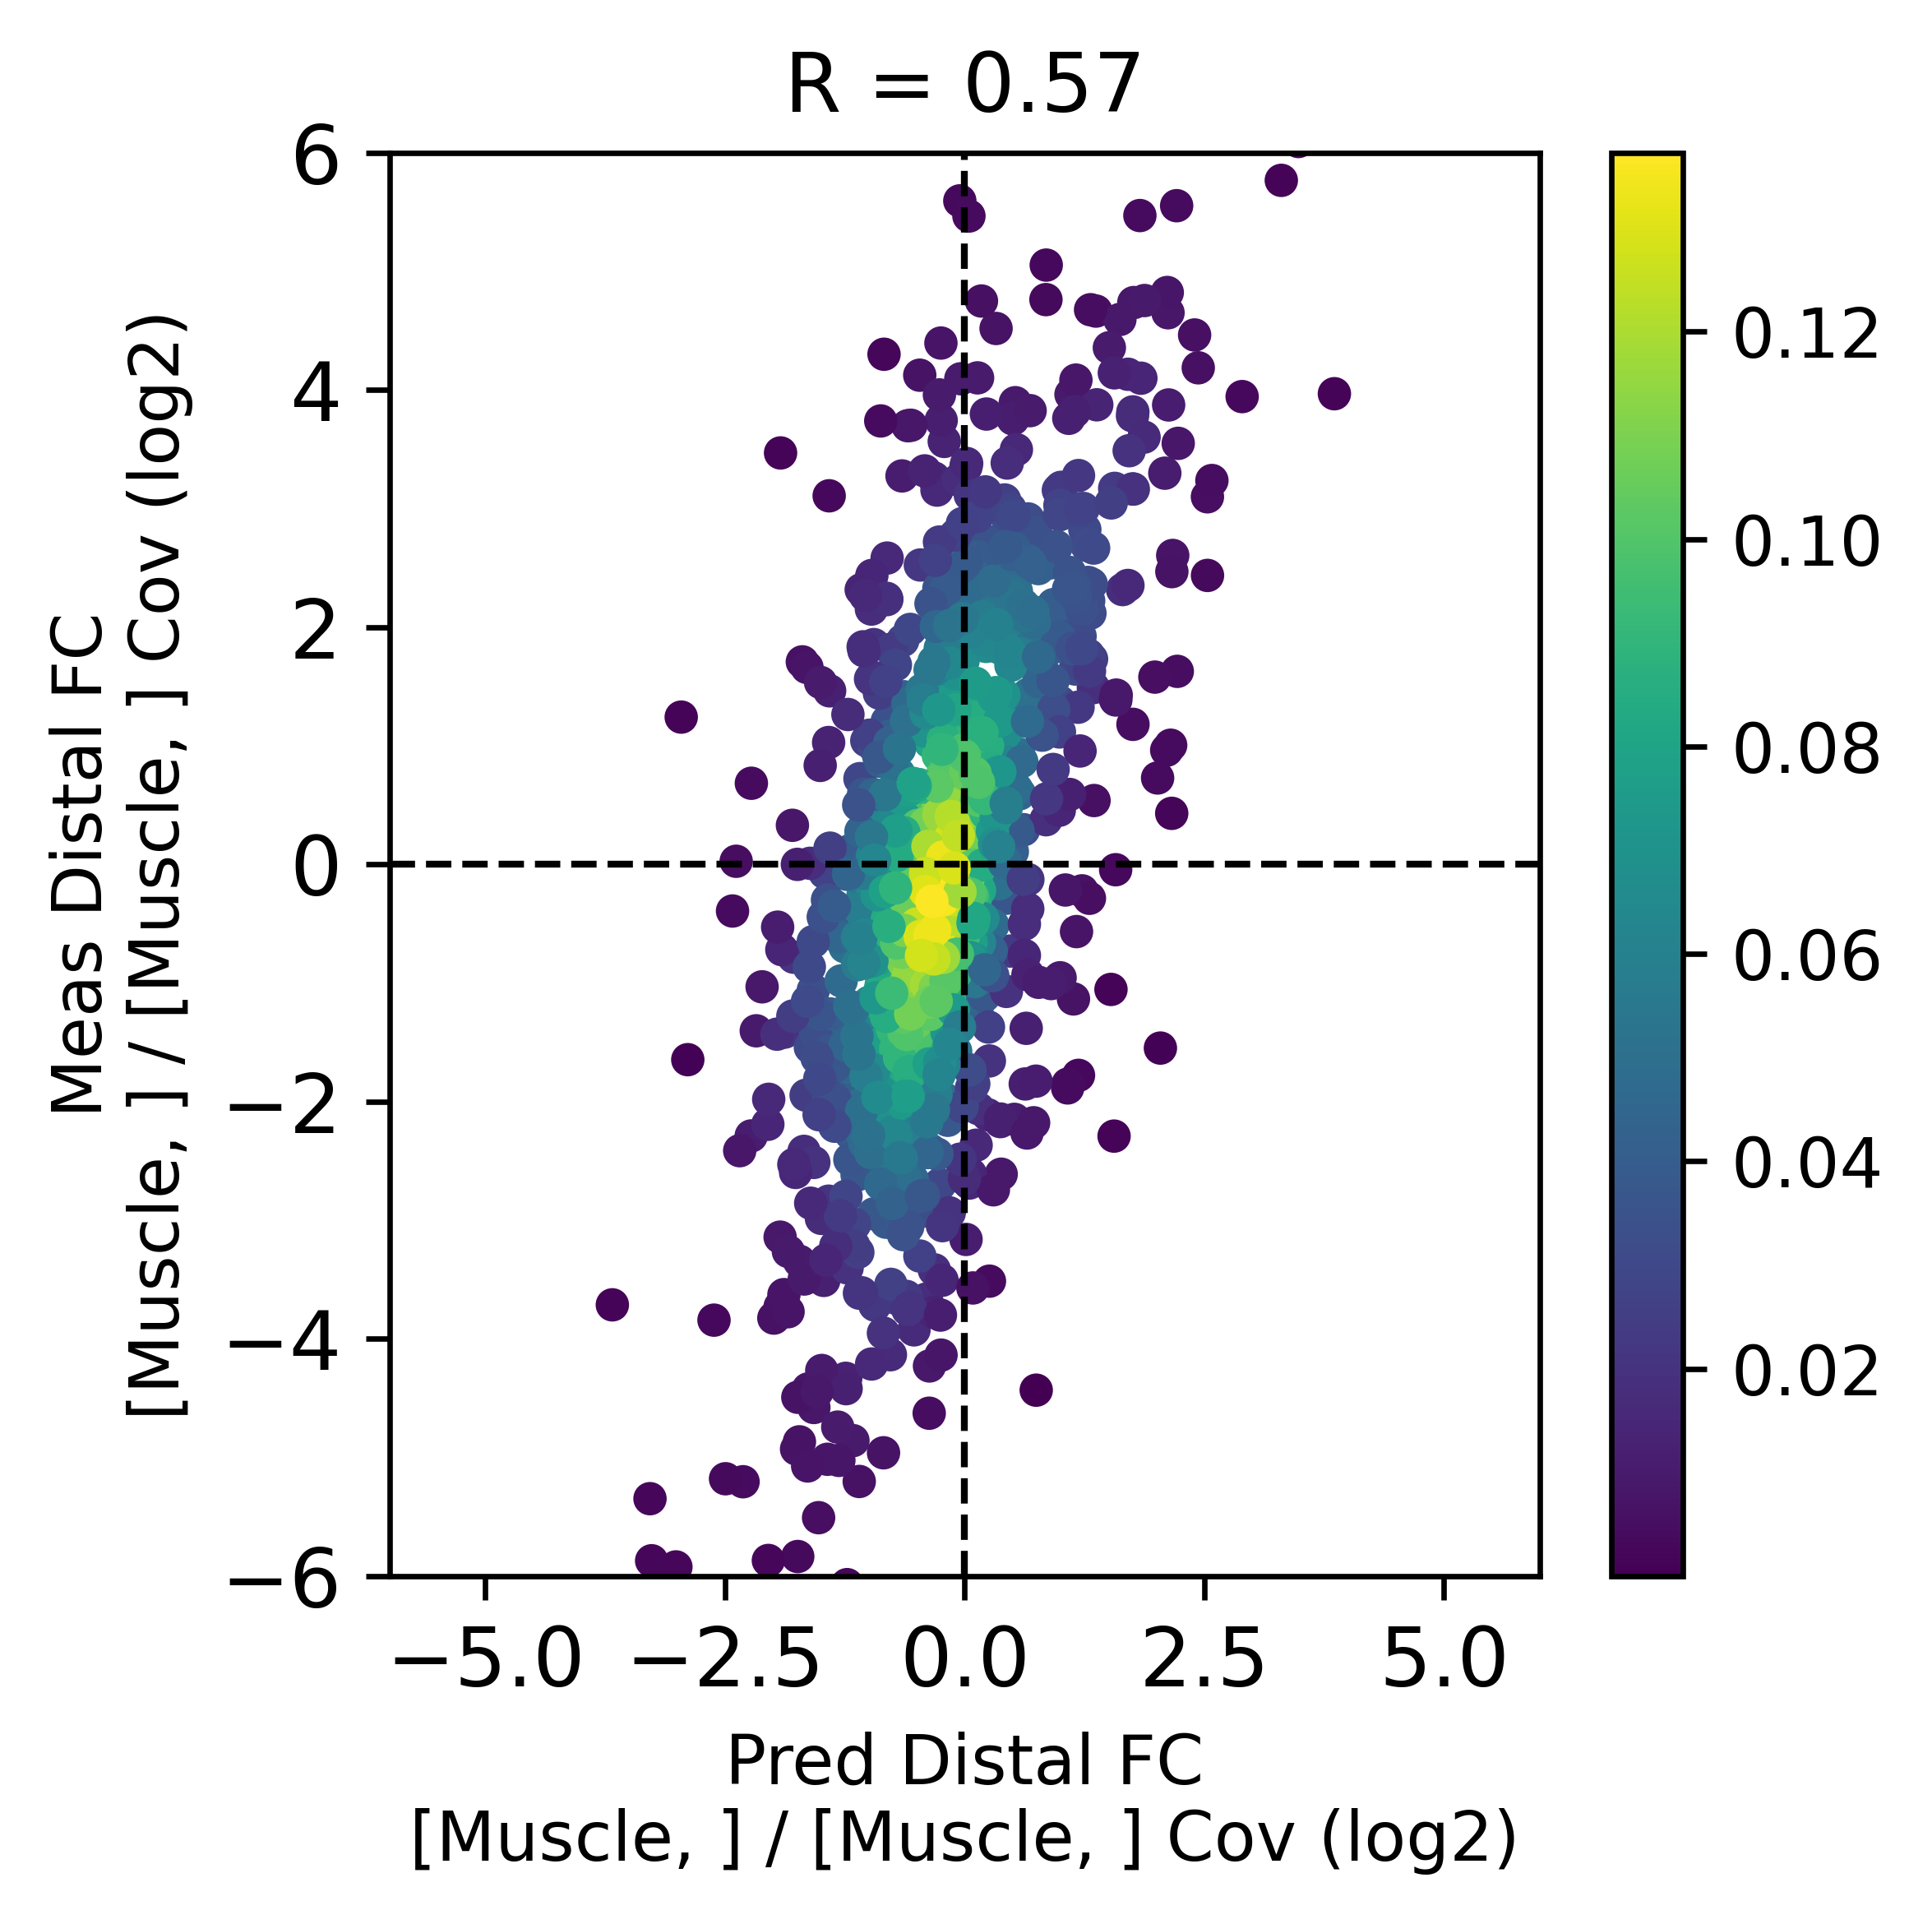

spearman r = 0.575
p = 9.109792584310547e-116
n = 994
(pearson r = 0.64)


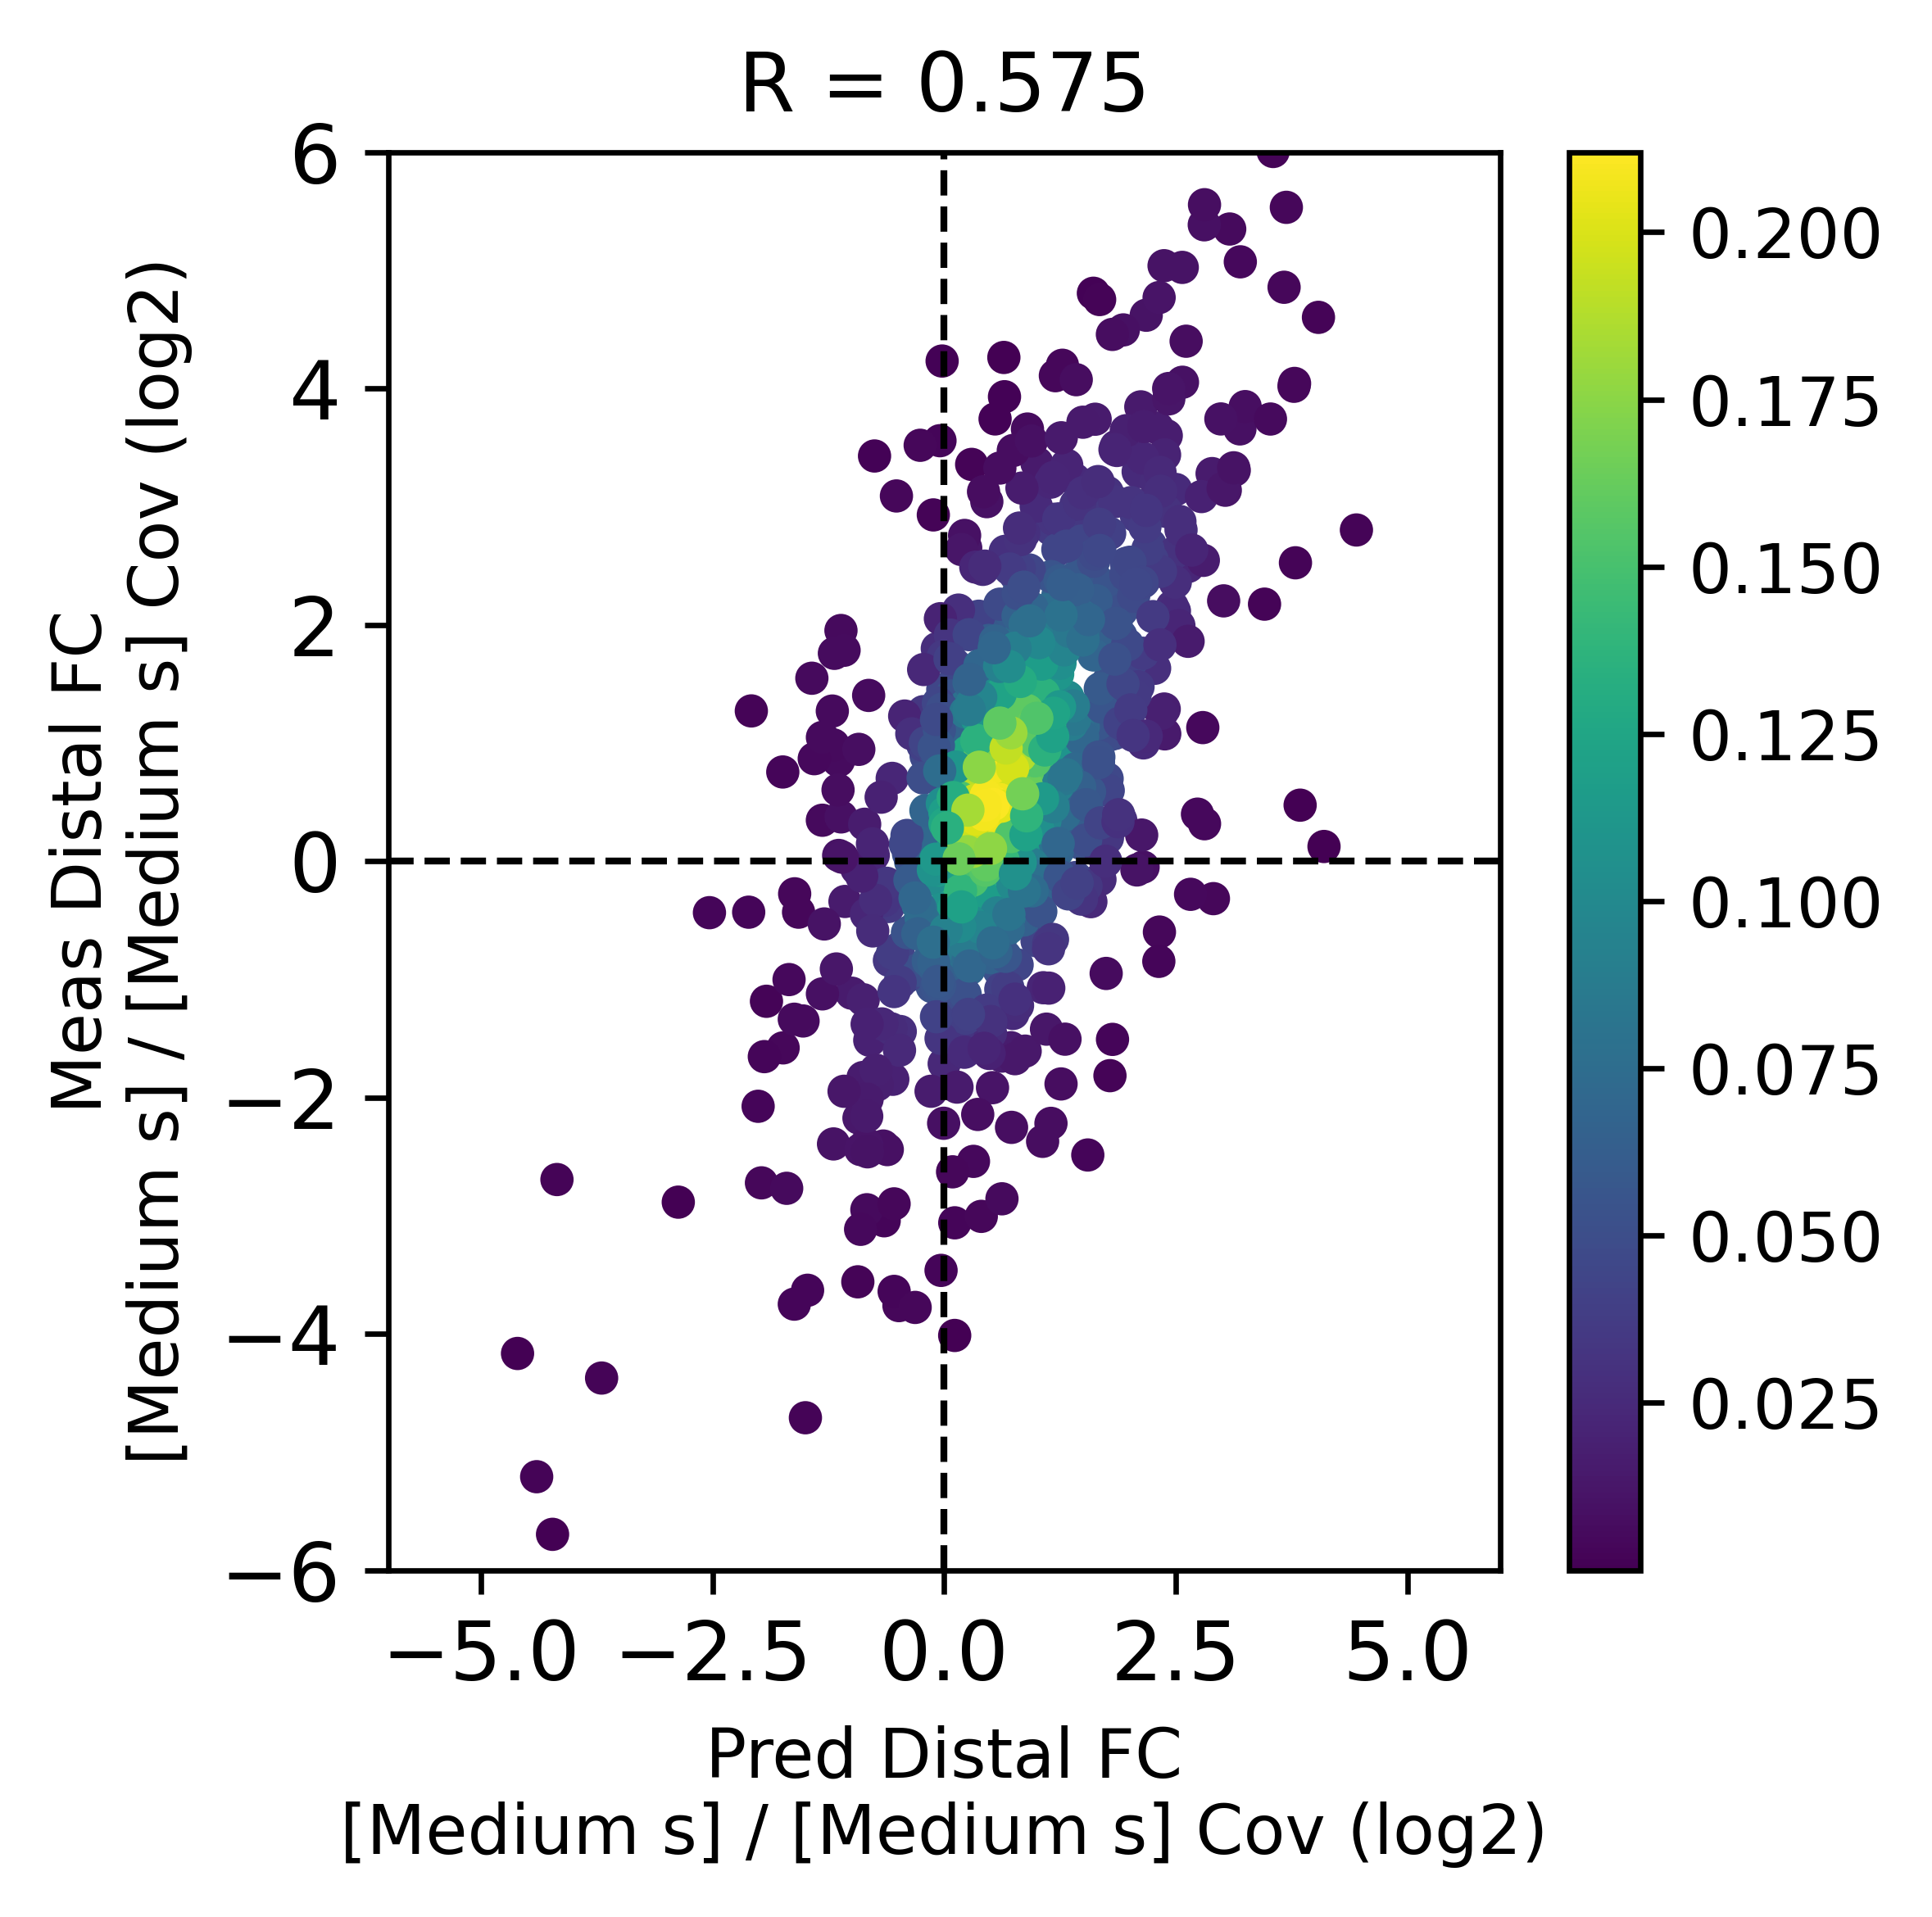

Predicting for cross = 0
Predicting for cross = 1
Predicting for cross = 2
Predicting for cross = 3


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


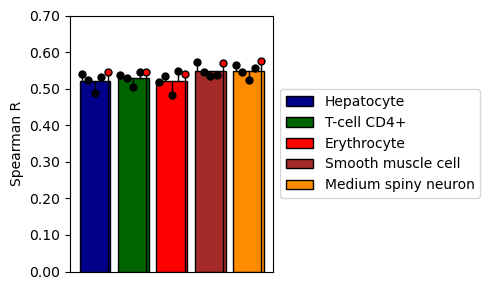

In [9]:
#Evaluate differential (tissue-specific) APA use on held-out test genes

import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde

fold_ix = 3
cross_index = [0, 1, 2, 3]

tissue_pairs = [
    ['Liver, hepatocyte', 'Liver, hepatocyte_other'],
    ['Lymph_Node, cd4-positive alpha-beta t cell', 'Lymph_Node, cd4-positive alpha-beta t cell_other'],
    ['Blood, erythrocyte', 'Blood, erythrocyte_other'],
    ['Muscle, smooth muscle cell', 'Muscle, smooth muscle cell_other'],
    ['Medium spiny neuron', 'Medium spiny neuron_other'],
]

rs_mat = np.zeros((len(tissue_pairs), 4 + 1), dtype='float32')

#Evaluate for fold (ensemble)

print("Evaluating for fold = " + str(fold_ix))

test_df = apa_df.loc[(~apa_df['test_fold'].isnull()) & (apa_df['test_fold'] == 'f' + str(fold_ix))].copy().reset_index(drop=True)

#Re-sort
test_df['sort_order'] = test_df['position_hg38']
test_df.loc[test_df['strand'] == '-', 'sort_order'] = -test_df.loc[test_df['strand'] == '-']['position_hg38']
test_df = test_df.sort_values(by=['gene', 'sort_order']).copy().reset_index(drop=True)

#Aggregate (tissue- or cell type-specific) gene-level statistics (distal usage proportions, etc.)

agg_dict = {
    'exon_overlap' : ['first', 'last'],
    'antisense_overlap' : ['first', 'last'],
    'strand' : ['first', 'last'],
    'position_hg38' : ['first', 'last'],
}
for tissue in tissues :
    agg_dict[tissue + '_pred'] = ['first', 'last', 'sum']
    agg_dict[tissue + '_true'] = ['first', 'last', 'sum']

agg_dict['Blood, erythrocyte_pred'].append('count')

gene_df = test_df.groupby(['gene']).agg(agg_dict)

gene_df.columns = ['_'.join(col).strip() for col in gene_df.columns.values]

gene_df = gene_df.reset_index().copy()

rename_dict = {
    'exon_overlap_first' :  'prox_exon_overlap',
    'antisense_overlap_first' :  'prox_antisense_overlap',
    'exon_overlap_last' :  'dist_exon_overlap',
    'antisense_overlap_last' :  'dist_antisense_overlap',
    'strand_first' :  'strand',
    'position_hg38_first' : 'prox_pos',
    'position_hg38_last' : 'dist_pos',
    'Blood, erythrocyte_pred_count' : 'n_sites',
}
for tissue in tissues :
    rename_dict[tissue + '_pred_first'] = tissue + '_prox_pred'
    rename_dict[tissue + '_pred_last'] = tissue + '_dist_pred'
    rename_dict[tissue + '_pred_sum'] = tissue + '_total_pred'
    rename_dict[tissue + '_true_first'] = tissue + '_prox_true'
    rename_dict[tissue + '_true_last'] = tissue + '_dist_true'
    rename_dict[tissue + '_true_sum'] = tissue + '_total_true'

gene_df = gene_df.rename(columns=rename_dict)

gene_df = gene_df.query("n_sites > 1").copy().reset_index(drop=True)
gene_df = gene_df.query("prox_antisense_overlap == False and dist_antisense_overlap == False").copy().reset_index(drop=True)
gene_df = gene_df.query("(strand == '+' and dist_pos - prox_pos >= 128) or (strand == '-' and prox_pos - dist_pos >= 128)").copy().reset_index(drop=True)

for tissue in tissues :
    gene_df[tissue + '_ratio_pred'] = gene_df[tissue + '_dist_pred'] / gene_df[tissue + '_total_pred']
    gene_df[tissue + '_ratio_true'] = gene_df[tissue + '_dist_true'] / gene_df[tissue + '_total_true']

    gene_df = gene_df.copy()

#Compare predicted vs. measured Distal / Proximal coverage ratios (derived from RNA-seq tracks)

for tissue_pair_i, tissue_pair in enumerate(tissue_pairs) :

    tissue_df = gene_df.copy().reset_index(drop=True)

    [tissue_1, tissue_2] = tissue_pair

    tissue_df['cov_ratio_1_pred'] = tissue_df[tissue_1 + '_ratio_pred']
    tissue_df['cov_ratio_1_true'] = tissue_df[tissue_1 + '_ratio_true']

    tissue_df['cov_ratio_2_pred'] = tissue_df[tissue_2 + '_ratio_pred']
    tissue_df['cov_ratio_2_true'] = tissue_df[tissue_2 + '_ratio_true']

    tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_ratio_1_pred']) | np.isinf(tissue_df['cov_ratio_1_pred'])) | (tissue_df['cov_ratio_1_pred'] == 0.))].copy().reset_index(drop=True)
    tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_ratio_1_true']) | np.isinf(tissue_df['cov_ratio_1_true'])) | (tissue_df['cov_ratio_1_true'] == 0.))].copy().reset_index(drop=True)
    tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_ratio_2_pred']) | np.isinf(tissue_df['cov_ratio_2_pred'])) | (tissue_df['cov_ratio_2_pred'] == 0.))].copy().reset_index(drop=True)
    tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_ratio_2_true']) | np.isinf(tissue_df['cov_ratio_2_true'])) | (tissue_df['cov_ratio_2_true'] == 0.))].copy().reset_index(drop=True)

    tissue_df['cov_ratio_pred'] = (tissue_df['cov_ratio_1_pred'] / (1. - tissue_df['cov_ratio_1_pred'])) / (tissue_df['cov_ratio_2_pred'] / (1. - tissue_df['cov_ratio_2_pred']))
    tissue_df['cov_ratio_true'] = (tissue_df['cov_ratio_1_true'] / (1. - tissue_df['cov_ratio_1_true'])) / (tissue_df['cov_ratio_2_true'] / (1. - tissue_df['cov_ratio_2_true']))

    cov_pred = np.log2(tissue_df['cov_ratio_pred'].values + 1e-6)
    cov_true = np.log2(tissue_df['cov_ratio_true'].values + 1e-6)

    sample_index = np.arange(len(gene_df), dtype='int32')
    np.random.shuffle(sample_index)
    sample_index = sample_index[:n_kde_sample]

    vals = np.concatenate([
        np.copy(cov_pred)[None, :],
        np.copy(cov_true)[None, :],
    ], axis=0)

    gkernel = gaussian_kde(vals[:, sample_index])(vals)

    rs_val, p_val = spearmanr(cov_pred, cov_true)
    rp_val, p_val = pearsonr(cov_pred, cov_true)

    rs_mat[tissue_pair_i, -1] = rs_val

    print("spearman r = " + str(round(rs_val, 3)))
    print("p = " + str(p_val))
    print("n = " + str(len(gene_df)))

    print("(pearson r = " + str(round(rp_val, 3)) + ")")

    #Plot as density KDE
    f = None
    if not save_figs :
        f = plt.figure(figsize=(4, 4))
    else :
        f = plt.figure(figsize=(4, 4), dpi=600)

    plt.scatter(cov_pred, cov_true, s=15, c=gkernel, cmap='viridis', rasterized=True)

    plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
    plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

    if plot_with_kde_bar :
        plt.colorbar()

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlim(-6, 6)
    plt.ylim(-6, 6)

    plt.xlabel("Pred Distal FC\n[" + tissue_1[:8] + "] / [" + tissue_2[:8] + "] Cov (log2)", fontsize=10)
    plt.ylabel("Meas Distal FC\n[" + tissue_1[:8] + "] / [" + tissue_2[:8] + "] Cov (log2)", fontsize=10)

    plt.title(label="R = " + str(round(rs_val, 3)))

    plt.tight_layout()

    if save_figs :
        plt.savefig('borzoi_v4_cov' + save_suffix + '_fold_' + str(fold_ix) + '_tissue_' + str(tissue_pair_i) + '_kde.png', dpi=600)
        plt.savefig('borzoi_v4_cov' + save_suffix + '_fold_' + str(fold_ix) + '_tissue_' + str(tissue_pair_i) + '_kde.pdf')

    plt.show()

#Loop over crosses
for cross_ix in cross_index :
    print("Predicting for cross = " + str(cross_ix))

    test_df = apa_df_cross.loc[(~apa_df_cross['test_cross'].isnull()) & (apa_df_cross['test_cross'] == 'c' + str(cross_ix))].copy().reset_index(drop=True)
    
    #Re-sort
    test_df['sort_order'] = test_df['position_hg38']
    test_df.loc[test_df['strand'] == '-', 'sort_order'] = -test_df.loc[test_df['strand'] == '-']['position_hg38']
    test_df = test_df.sort_values(by=['gene', 'sort_order']).copy().reset_index(drop=True)

    #Aggregate (tissue- or cell type-specific) gene-level statistics (distal usage proportions, etc.)

    agg_dict = {
        'exon_overlap' : ['first', 'last'],
        'antisense_overlap' : ['first', 'last'],
        'strand' : ['first', 'last'],
        'position_hg38' : ['first', 'last'],
    }
    for tissue in tissues :
        agg_dict[tissue + '_pred'] = ['first', 'last', 'sum']
        agg_dict[tissue + '_true'] = ['first', 'last', 'sum']

    agg_dict['Blood, erythrocyte_pred'].append('count')

    gene_df = test_df.groupby(['gene']).agg(agg_dict)

    gene_df.columns = ['_'.join(col).strip() for col in gene_df.columns.values]

    gene_df = gene_df.reset_index().copy()

    rename_dict = {
        'exon_overlap_first' :  'prox_exon_overlap',
        'antisense_overlap_first' :  'prox_antisense_overlap',
        'exon_overlap_last' :  'dist_exon_overlap',
        'antisense_overlap_last' :  'dist_antisense_overlap',
        'strand_first' :  'strand',
        'position_hg38_first' : 'prox_pos',
        'position_hg38_last' : 'dist_pos',
        'Blood, erythrocyte_pred_count' : 'n_sites',
    }
    for tissue in tissues :
        rename_dict[tissue + '_pred_first'] = tissue + '_prox_pred'
        rename_dict[tissue + '_pred_last'] = tissue + '_dist_pred'
        rename_dict[tissue + '_pred_sum'] = tissue + '_total_pred'
        rename_dict[tissue + '_true_first'] = tissue + '_prox_true'
        rename_dict[tissue + '_true_last'] = tissue + '_dist_true'
        rename_dict[tissue + '_true_sum'] = tissue + '_total_true'

    gene_df = gene_df.rename(columns=rename_dict)

    gene_df = gene_df.query("n_sites > 1").copy().reset_index(drop=True)
    gene_df = gene_df.query("prox_antisense_overlap == False and dist_antisense_overlap == False").copy().reset_index(drop=True)
    gene_df = gene_df.query("(strand == '+' and dist_pos - prox_pos >= 128) or (strand == '-' and prox_pos - dist_pos >= 128)").copy().reset_index(drop=True)

    for tissue in tissues :
        gene_df[tissue + '_ratio_pred'] = gene_df[tissue + '_dist_pred'] / gene_df[tissue + '_total_pred']
        gene_df[tissue + '_ratio_true'] = gene_df[tissue + '_dist_true'] / gene_df[tissue + '_total_true']

        gene_df = gene_df.copy()

    #Compare predicted vs. measured Distal / Proximal coverage ratios (derived from RNA-seq tracks)

    for tissue_pair_i, tissue_pair in enumerate(tissue_pairs) :

        tissue_df = gene_df.copy().reset_index(drop=True)

        [tissue_1, tissue_2] = tissue_pair

        tissue_df['cov_ratio_1_pred'] = tissue_df[tissue_1 + '_ratio_pred']
        tissue_df['cov_ratio_1_true'] = tissue_df[tissue_1 + '_ratio_true']

        tissue_df['cov_ratio_2_pred'] = tissue_df[tissue_2 + '_ratio_pred']
        tissue_df['cov_ratio_2_true'] = tissue_df[tissue_2 + '_ratio_true']

        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_ratio_1_pred']) | np.isinf(tissue_df['cov_ratio_1_pred'])) | (tissue_df['cov_ratio_1_pred'] == 0.))].copy().reset_index(drop=True)
        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_ratio_1_true']) | np.isinf(tissue_df['cov_ratio_1_true'])) | (tissue_df['cov_ratio_1_true'] == 0.))].copy().reset_index(drop=True)
        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_ratio_2_pred']) | np.isinf(tissue_df['cov_ratio_2_pred'])) | (tissue_df['cov_ratio_2_pred'] == 0.))].copy().reset_index(drop=True)
        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_ratio_2_true']) | np.isinf(tissue_df['cov_ratio_2_true'])) | (tissue_df['cov_ratio_2_true'] == 0.))].copy().reset_index(drop=True)

        tissue_df['cov_ratio_pred'] = (tissue_df['cov_ratio_1_pred'] / (1. - tissue_df['cov_ratio_1_pred'])) / (tissue_df['cov_ratio_2_pred'] / (1. - tissue_df['cov_ratio_2_pred']))
        tissue_df['cov_ratio_true'] = (tissue_df['cov_ratio_1_true'] / (1. - tissue_df['cov_ratio_1_true'])) / (tissue_df['cov_ratio_2_true'] / (1. - tissue_df['cov_ratio_2_true']))

        cov_pred = np.log2(tissue_df['cov_ratio_pred'].values + 1e-6)
        cov_true = np.log2(tissue_df['cov_ratio_true'].values + 1e-6)

        sample_index = np.arange(len(gene_df), dtype='int32')
        np.random.shuffle(sample_index)
        sample_index = sample_index[:n_kde_sample]

        vals = np.concatenate([
            np.copy(cov_pred)[None, :],
            np.copy(cov_true)[None, :],
        ], axis=0)

        gkernel = gaussian_kde(vals[:, sample_index])(vals)

        rs_val, p_val = spearmanr(cov_pred, cov_true)
        rp_val, p_val = pearsonr(cov_pred, cov_true)

        rs_mat[tissue_pair_i, cross_ix] = rs_val

#Plot performance summary (4 cross + 1 ensemble); with individual fold performance as dots
f = plt.figure(figsize=(5, 3)) #, dpi=300

model_colors = [
    'darkblue',
    'darkgreen',
    'red',
    'brown',
    'darkorange',
]

model_names = [
    'Hepatocyte',
    'T-cell CD4+',
    'Erythrocyte',
    'Smooth muscle cell',
    'Medium spiny neuron',
]

for i in range(rs_mat.shape[0]) :
    rs_mean = np.mean(rs_mat[i, :-1])
    plt.bar([i], rs_mean, width=0.8, edgecolor='black', color=model_colors[i], linewidth=1, zorder=0, label=model_names[i])
    
    #Plot individual cross performance
    for j in range(4) :
        plt.plot([
            i + (j+1) * (1. / (5 + 1.)) - 0.5,
            i + (j+1) * (1. / (5 + 1.)) - 0.5
        ], [rs_mean, rs_mat[i, j]], linewidth=1, color='black', linestyle='-', zorder=1)
        
        plt.scatter([
            i + (j+1) * (1. / (5 + 1.)) - 0.5
        ], [rs_mat[i, j]], edgecolor='black', linewidth=1, color='black', s=25, zorder=2)
    
    #Plot ensemble performance
    plt.plot([
        i + 5 * (1. / (5 + 1.)) - 0.5,
        i + 5 * (1. / (5 + 1.)) - 0.5
    ], [0.0, rs_mat[i, -1]], linewidth=1, color='black', linestyle='-', zorder=3)

    plt.scatter([
        i + 5 * (1. / (5 + 1.)) - 0.5
    ], [rs_mat[i, -1]], edgecolor='black', linewidth=1, color='red', s=25, zorder=4)

plt.xticks([], [])
plt.yticks(fontsize=10)

plt.ylabel("Spearman R", fontsize=10)

plt.ylim(0.0, 0.7)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v4_cov' + save_suffix + '_tissues_bars.png', dpi=600)
    plt.savefig('borzoi_v4_cov' + save_suffix + '_tissues_bars.eps')

plt.show()
